<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 3/3: Réduction de dimension et EDA** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allons :
* Imputer les valeurs manquantes par la médiane
* Réduire le nombre de variable par la méthode SelectKBest
* Réduire le nombre de variable par la méthode RFE

# Importation des données et des librairies Python pour DS

In [54]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
import missingno as msno #missing data visualizations
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [10]:
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)

In [2]:
#num_rows = None  # 10000
train_df = pd.read_csv('data/traited/df_train_99.csv')  # , nrows=num_rows

In [3]:
train_df.head()

,EXT_SOURCE_1,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,ACTIVE_DAYS_CREDIT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,CLOSED_DAYS_CREDIT_MAX,...,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MAX,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,-9461,-103.0,-49.0,-2120,-1134.0,-476.0,...,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.0,100002
1,0.311267,0.027598,0.622246,NaN,-16765,-606.0,-544.0,-291,-828.0,-775.0,...,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.333333,0.333333,0.0,100003
2,NaN,0.050000,0.555912,0.729567,-19046,NaN,-727.0,-2531,-815.0,-408.0,...,0.000000,0.000000,NaN,1.000000,0.000000,NaN,0.000000,0.000000,0.0,100004
3,NaN,0.094941,0.650442,NaN,-19005,NaN,-12.0,-2437,-617.0,NaN,...,0.111111,0.333333,15.0,0.000000,0.000000,270000.0,0.111111,0.000000,0.0,100006
4,NaN,0.042623,0.322738,NaN,-19932,NaN,-14.0,-3458,-1106.0,-1149.0,...,0.000000,0.000000,NaN,0.166667,0.166667,NaN,0.500000,0.000000,0.0,100007


In [4]:
train_df.shape

(307507, 99)

In [49]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    #test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    #sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            #nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )

        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc',
                callbacks=[lgb.callback.early_stopping(stopping_rounds=200),
                           lgb.callback.log_evaluation(200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.4f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), sep='')
        print("\n")
     
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.4f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    
    # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    

    
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index  #[:40]
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances02png')

# Relation Target/Variables

In [18]:
train_df['TARGET'].value_counts(normalize=True)

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64

In [19]:
positive_df = train_df[train_df['TARGET']==1]
negative_df = train_df[train_df['TARGET']==0]

In [22]:
columns = train_df.drop(columns = ["TARGET"]).columns

 20%|████████████████▋                                                                 | 20/98 [00:06<00:21,  3.60it/s]C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\378665011.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


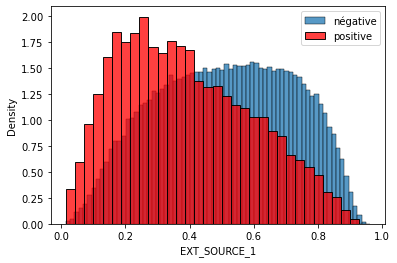

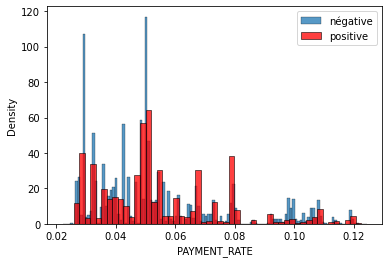

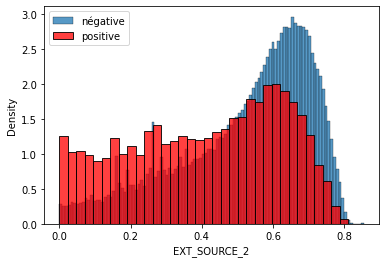

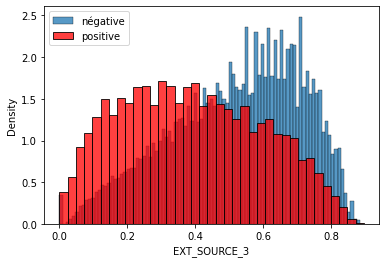

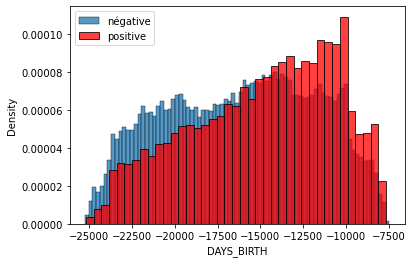

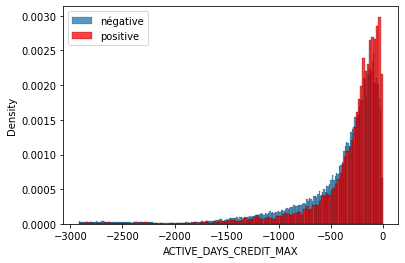

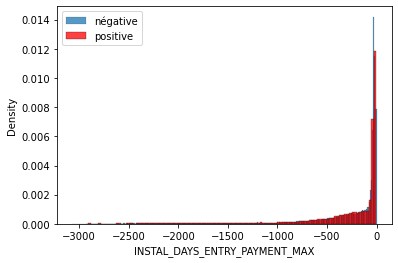

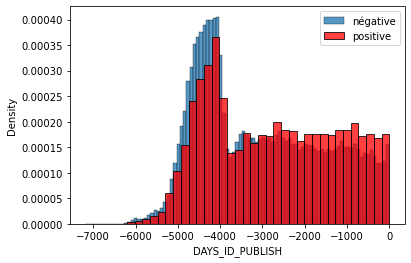

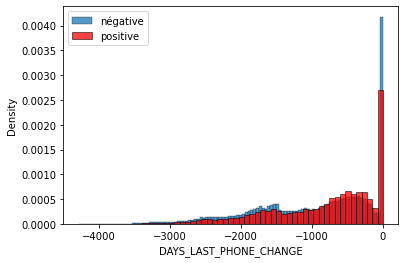

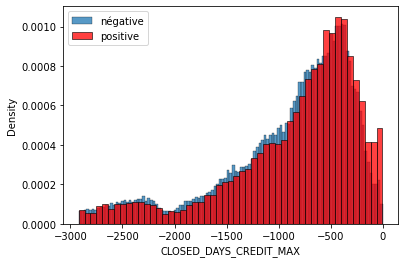

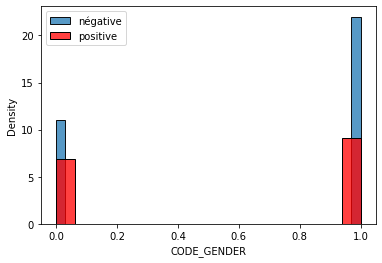

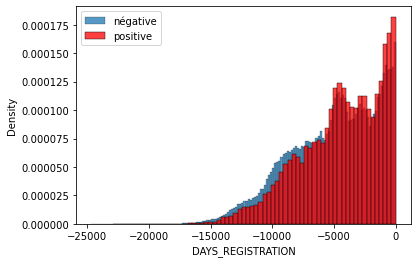

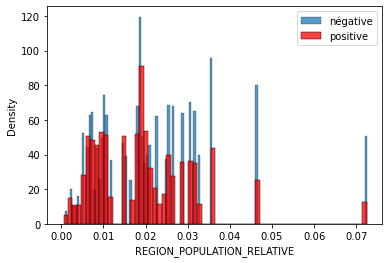

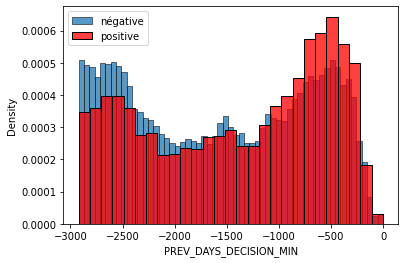

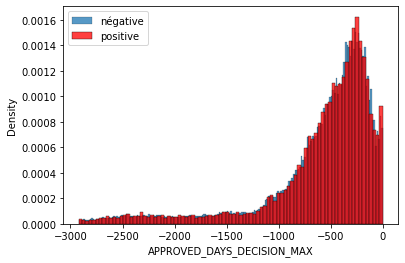

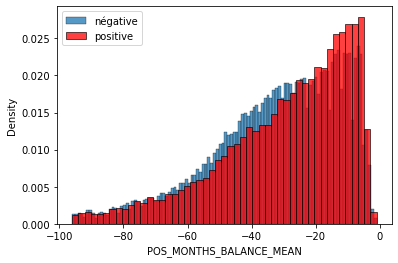

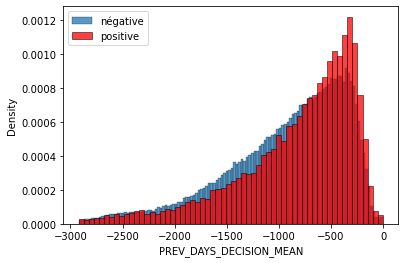

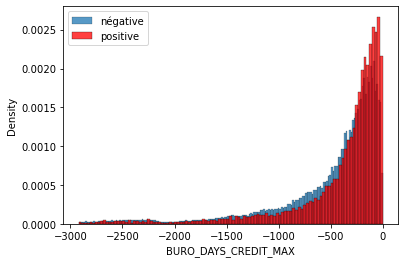

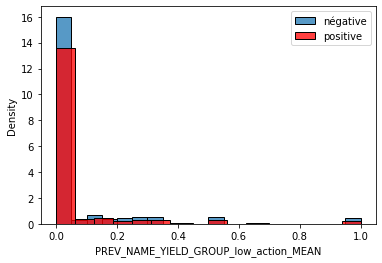

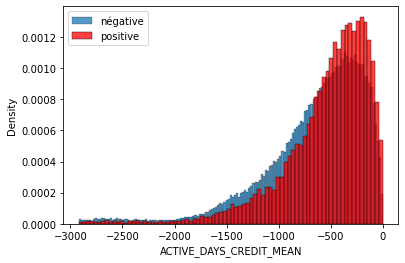

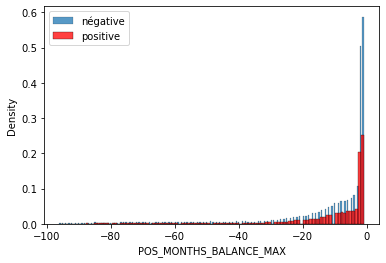

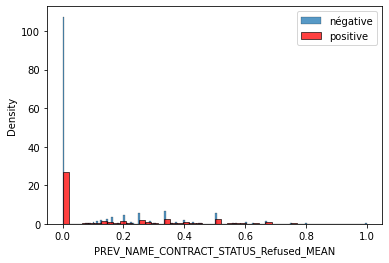

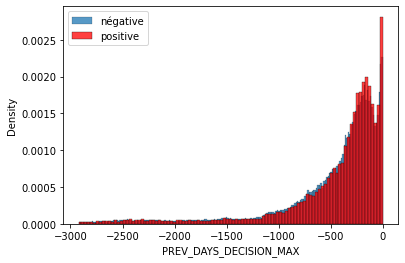

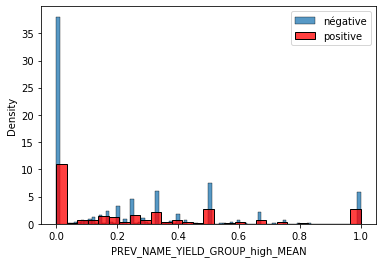

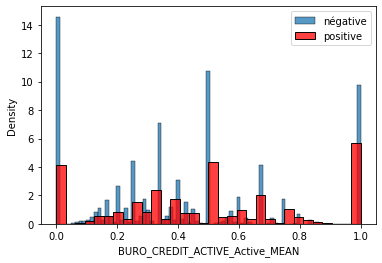

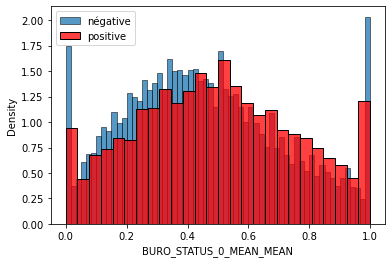

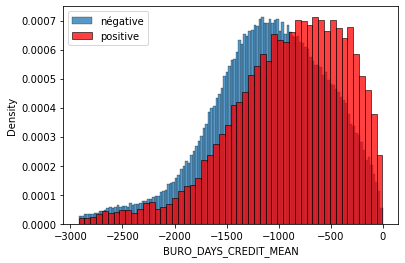

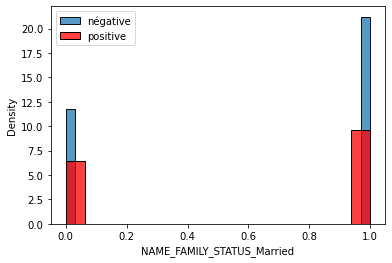

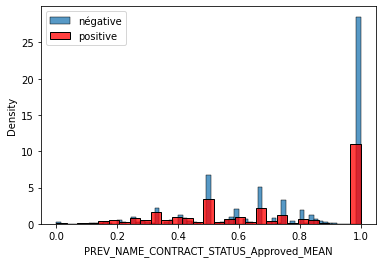

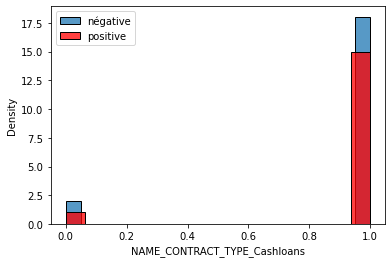

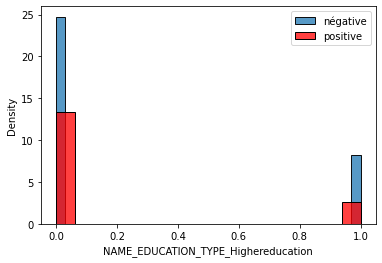

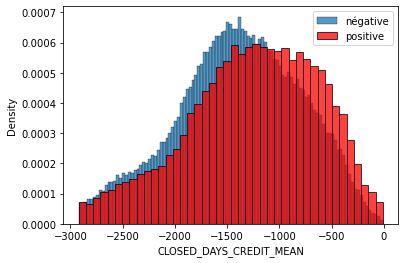

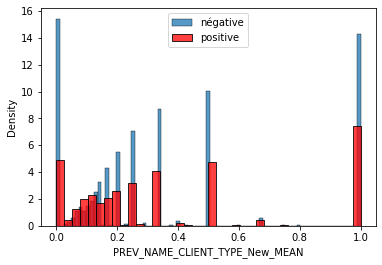

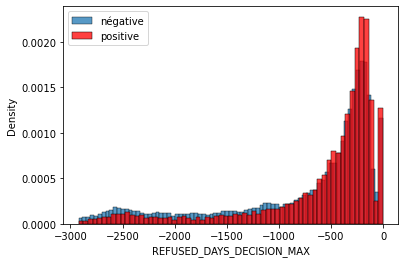

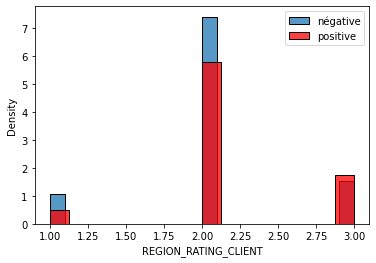

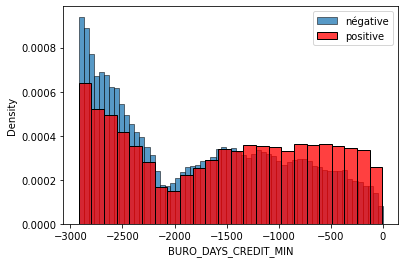

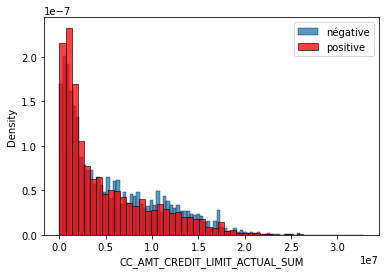

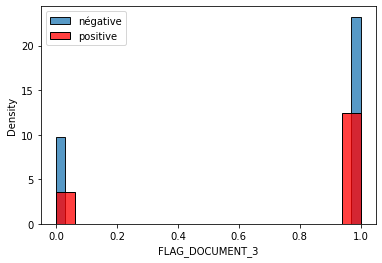

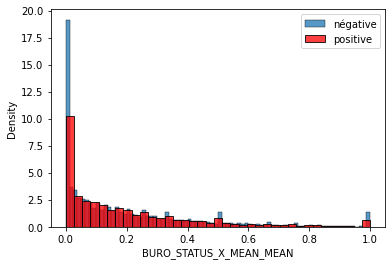

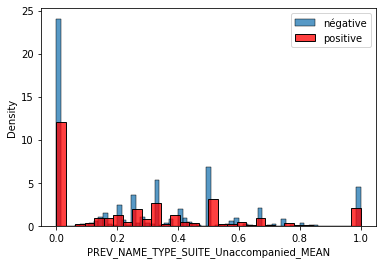

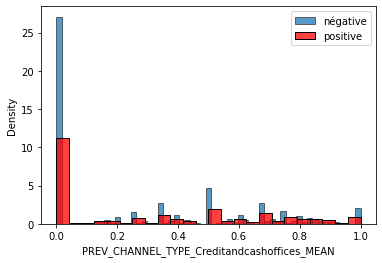

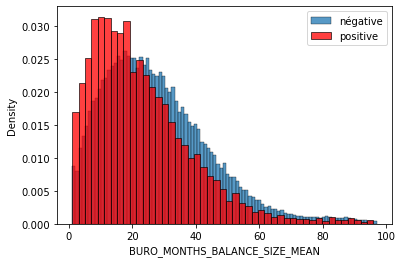

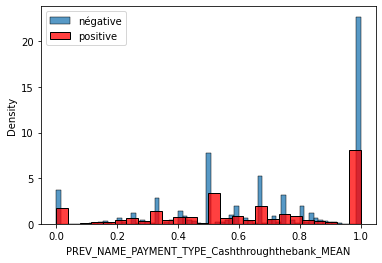

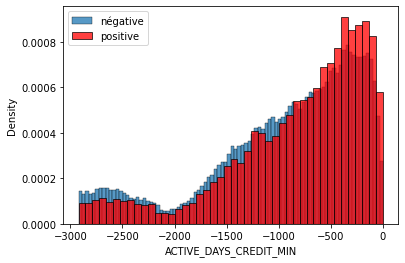

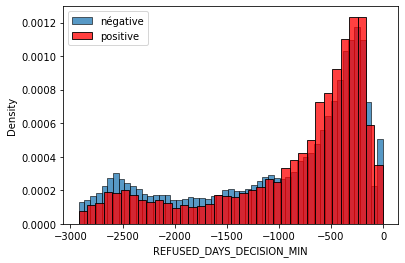

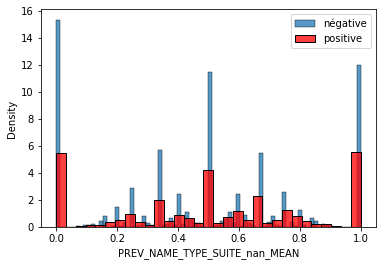

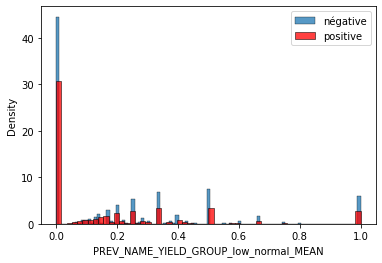

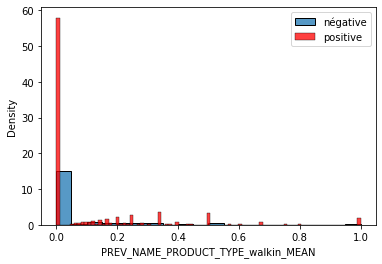

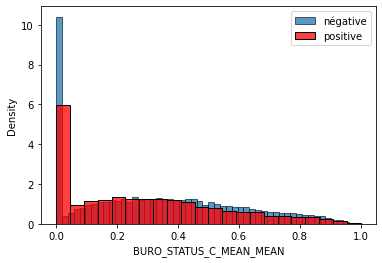

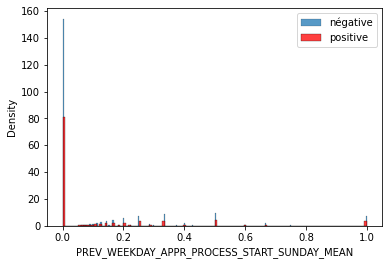

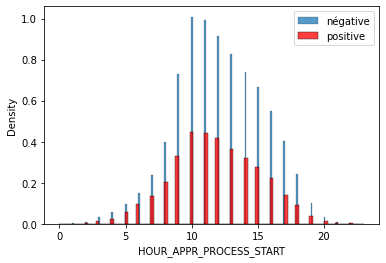

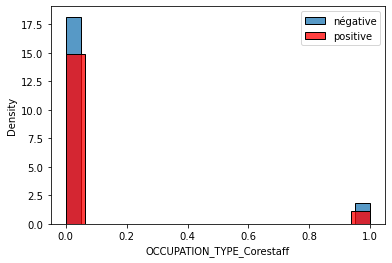

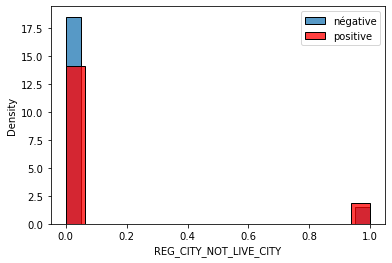

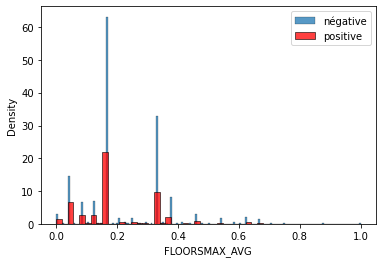

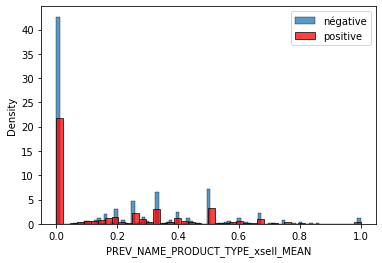

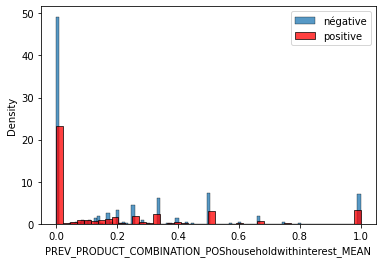

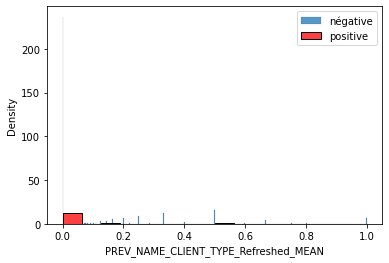

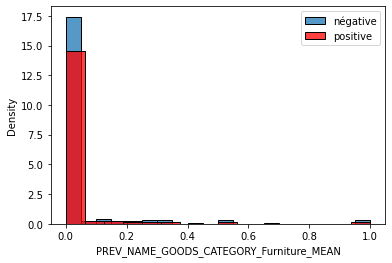

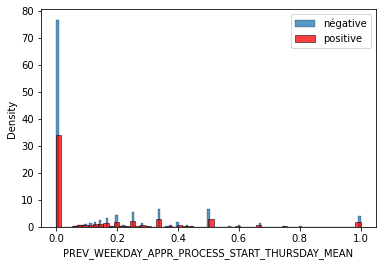

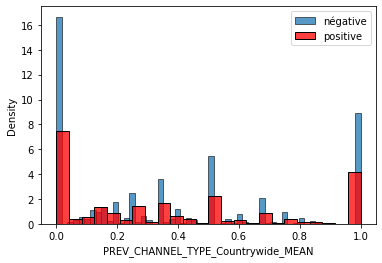

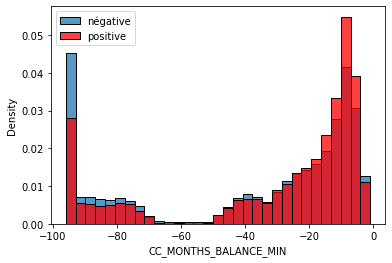

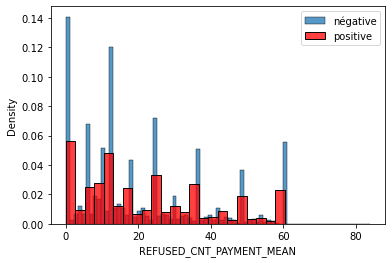

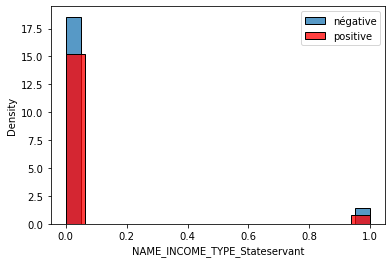

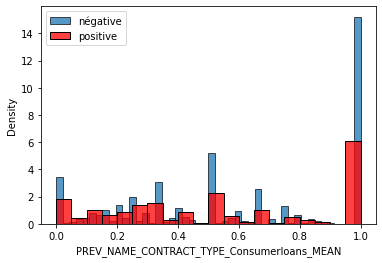

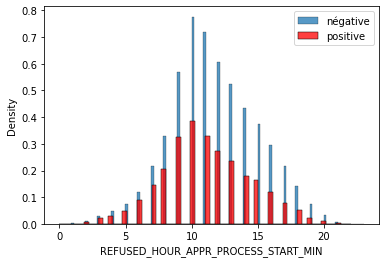

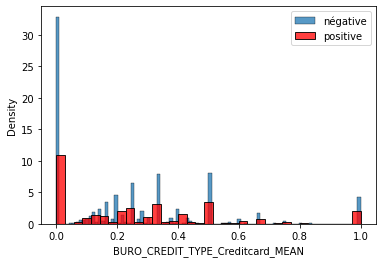

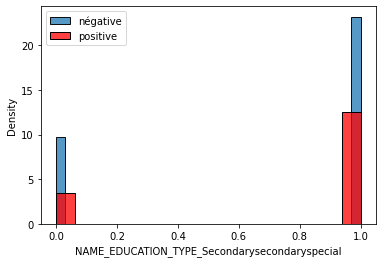

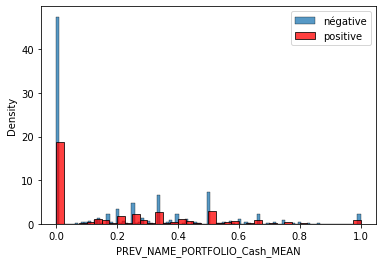

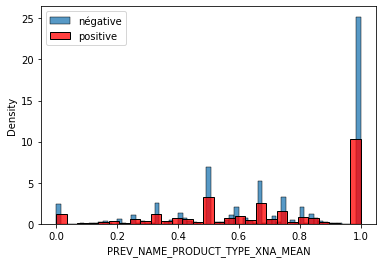

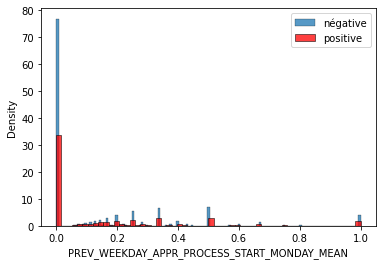

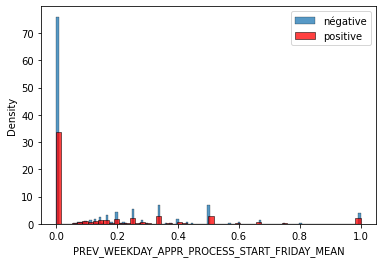

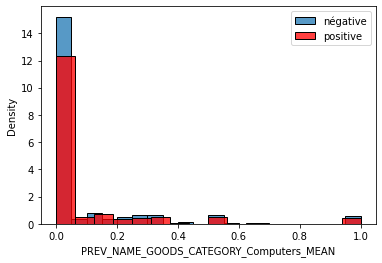

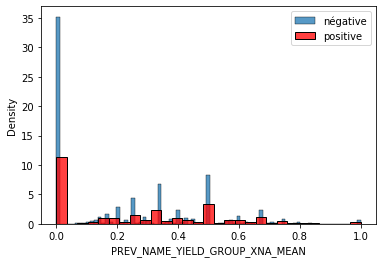

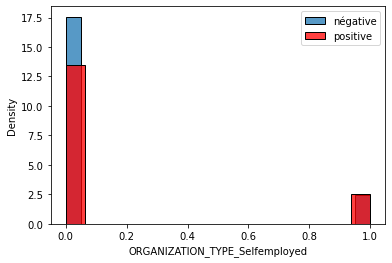

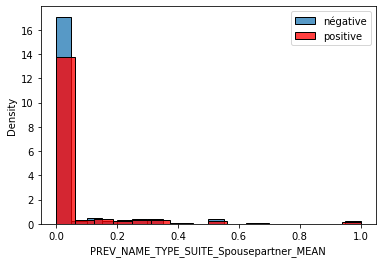

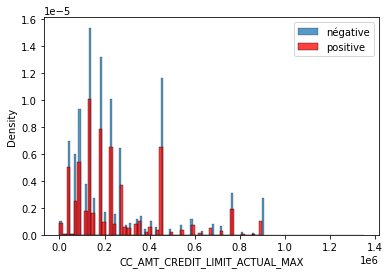

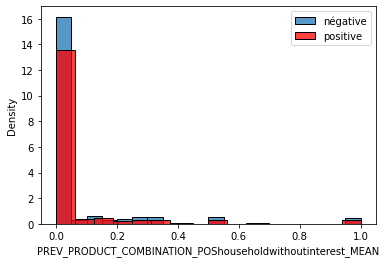

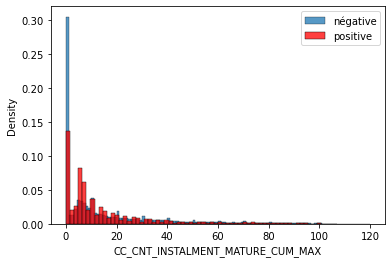

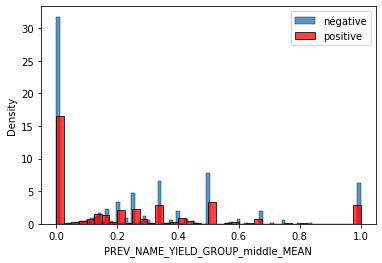

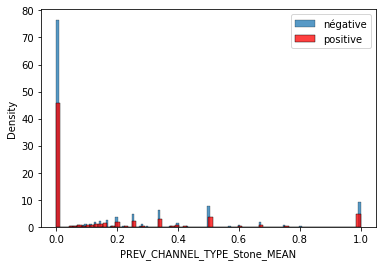

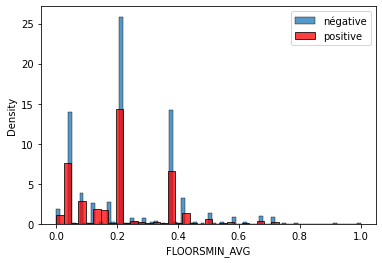

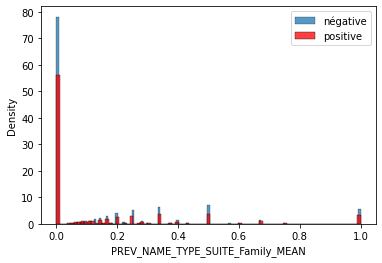

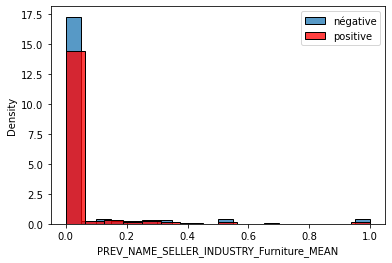

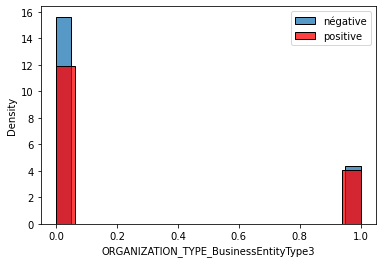

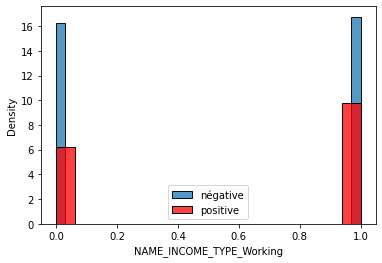

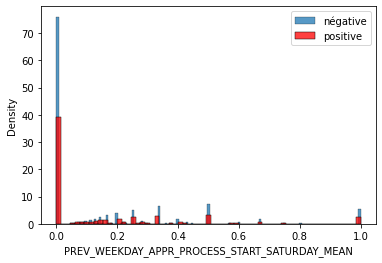

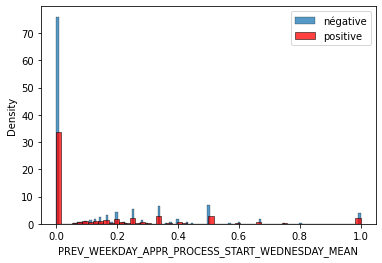

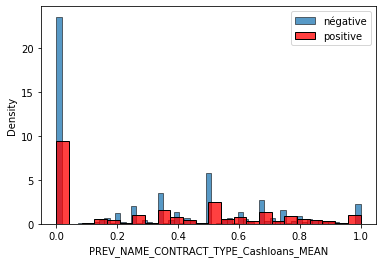

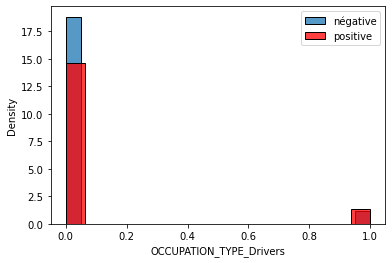

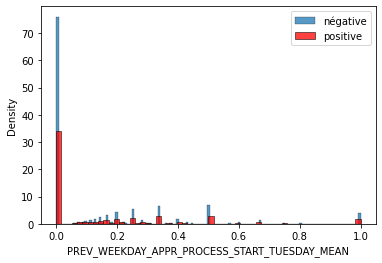

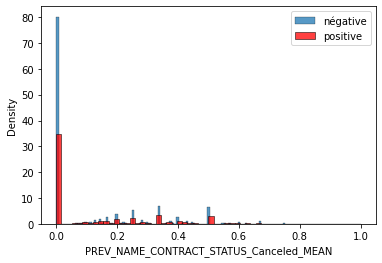

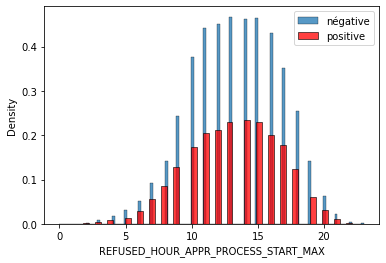

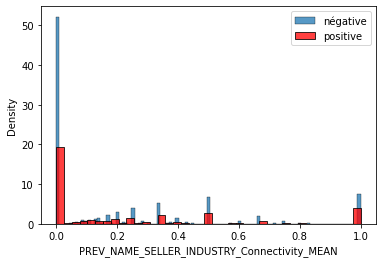

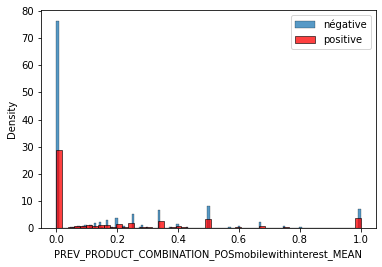

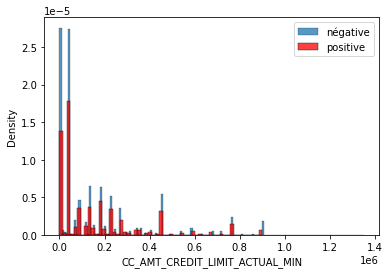

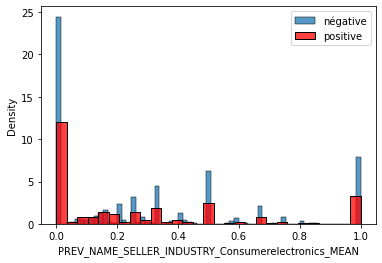

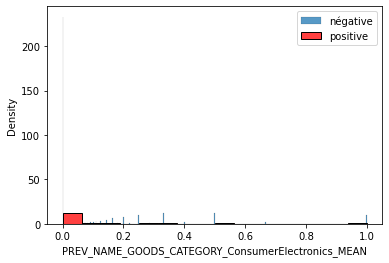

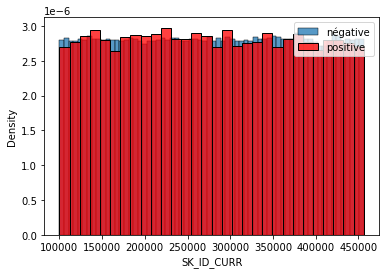

In [23]:
from tqdm import tqdm
for col in tqdm(columns):
    plt.figure()    
    sns.histplot(negative_df[col], label = 'négative', stat='density')
    sns.histplot(positive_df[col], label = 'positive', color='r',stat='density')
    plt.legend()

# Traitement des valeurs manquantes

In [24]:
train_missing = (train_df.isnull().sum() / len(train_df)).sort_values(ascending = False)
train_missing

CC_AMT_CREDIT_LIMIT_ACTUAL_SUM                               0.717389
CC_AMT_CREDIT_LIMIT_ACTUAL_MAX                               0.717389
CC_AMT_CREDIT_LIMIT_ACTUAL_MIN                               0.717389
CC_MONTHS_BALANCE_MIN                                        0.717389
CC_CNT_INSTALMENT_MATURE_CUM_MAX                             0.717389
REFUSED_CNT_PAYMENT_MEAN                                     0.702231
BURO_MONTHS_BALANCE_SIZE_MEAN                                0.700069
BURO_STATUS_0_MEAN_MEAN                                      0.700069
BURO_STATUS_X_MEAN_MEAN                                      0.700069
BURO_STATUS_C_MEAN_MEAN                                      0.700069
FLOORSMIN_AVG                                                0.678489
REFUSED_HOUR_APPR_PROCESS_START_MIN                          0.673861
REFUSED_DAYS_DECISION_MIN                                    0.673861
REFUSED_HOUR_APPR_PROCESS_START_MAX                          0.673861
REFUSED_DAYS_DECISIO

In [25]:
train_df_imp = train_df.fillna(train_df.median())

In [26]:
#train_df_imp.to_csv('data/traited/df_train_imp_median_99.csv', index = False)

In [27]:
positive_df_imp = train_df_imp[train_df_imp['TARGET']==1]
negative_df_imp = train_df_imp[train_df_imp['TARGET']==0]

 20%|████████████████▋                                                                 | 20/98 [00:08<00:35,  2.20it/s]C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\155835944.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


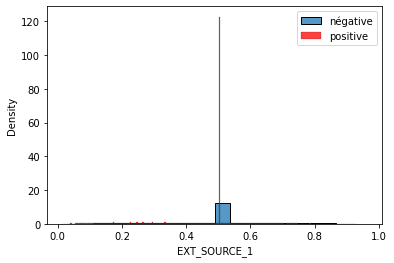

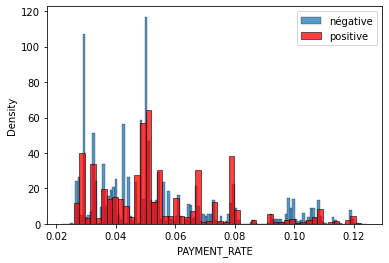

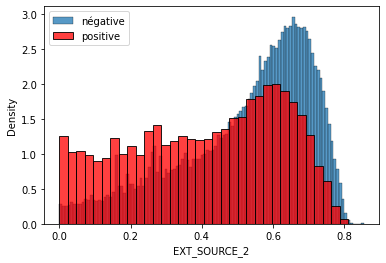

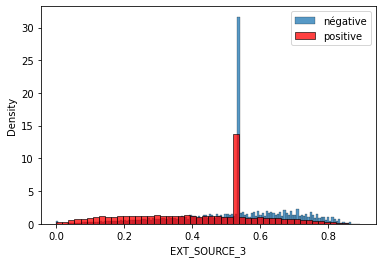

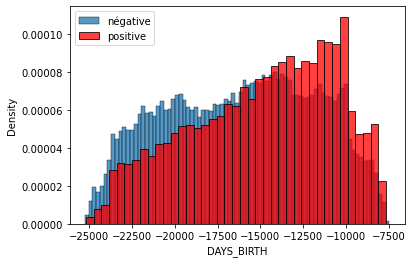

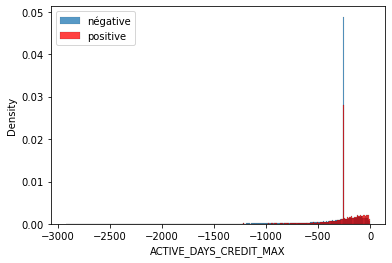

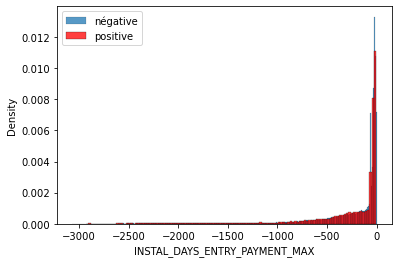

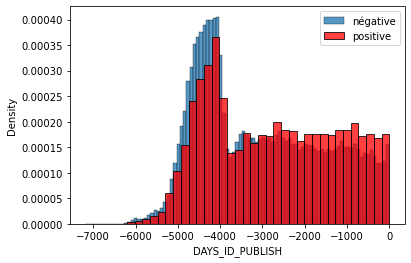

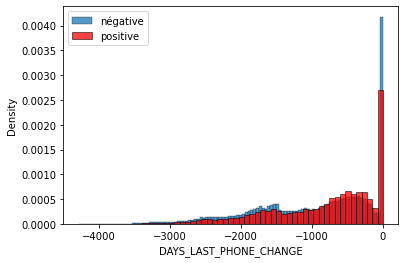

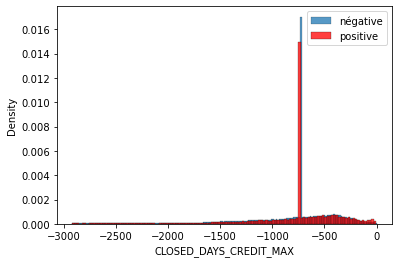

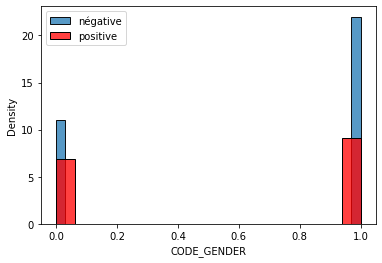

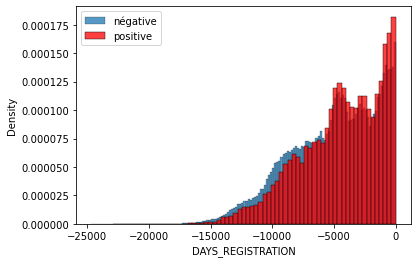

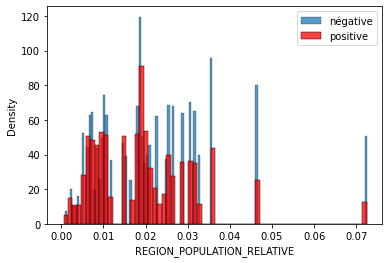

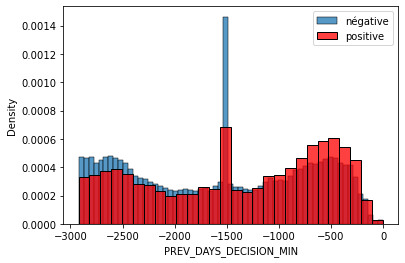

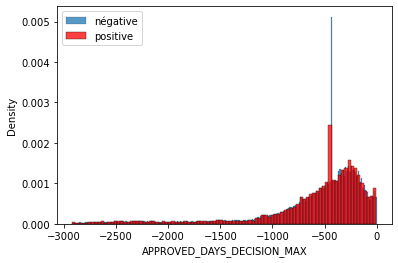

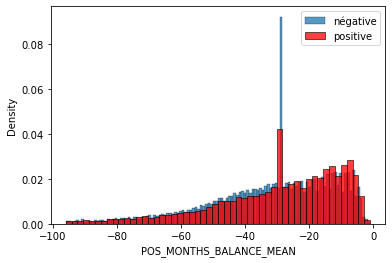

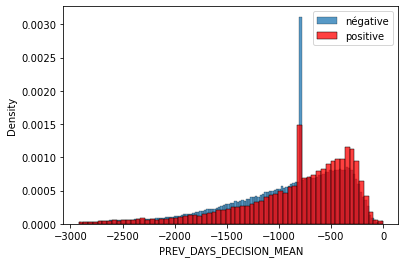

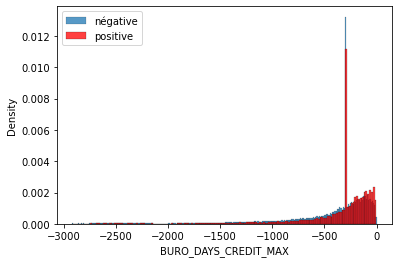

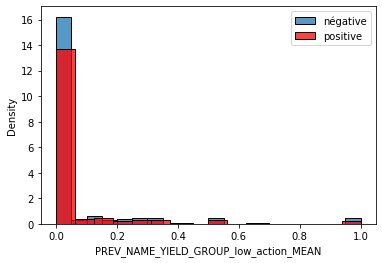

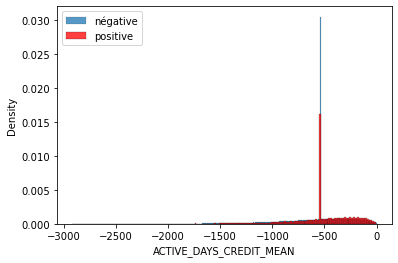

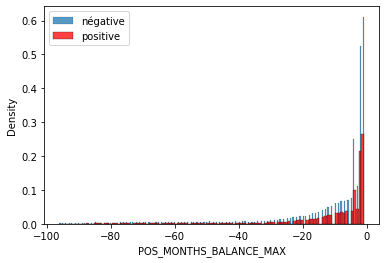

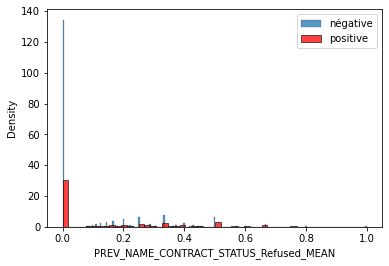

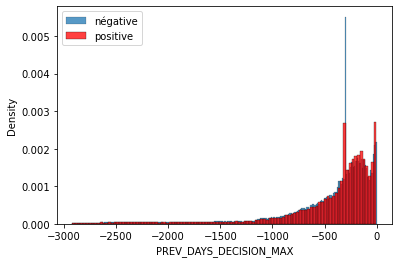

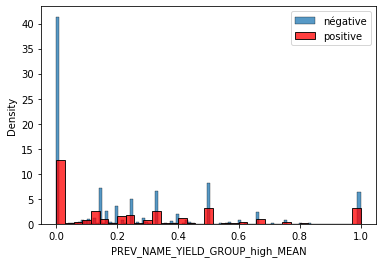

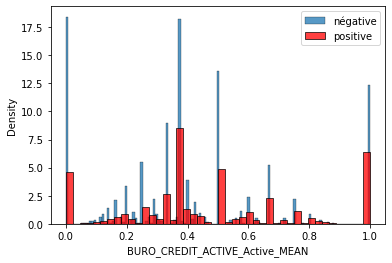

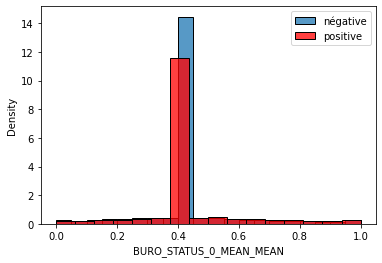

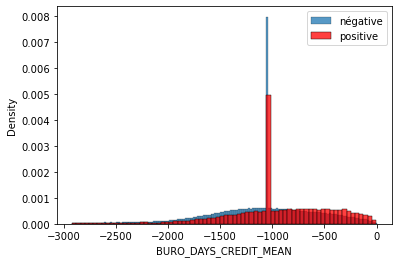

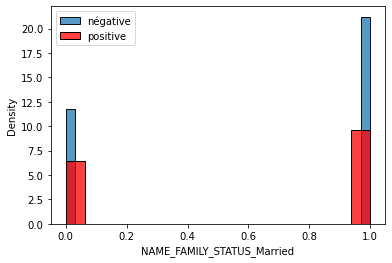

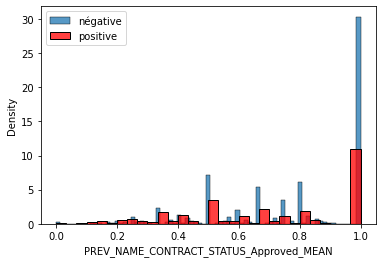

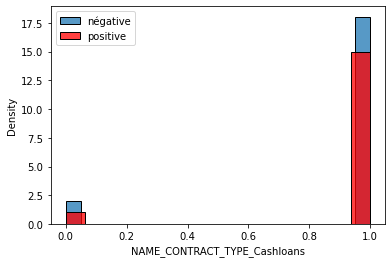

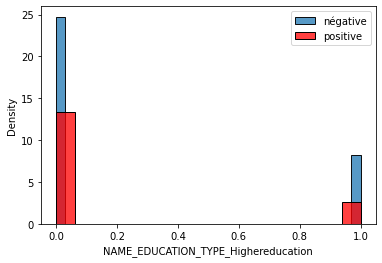

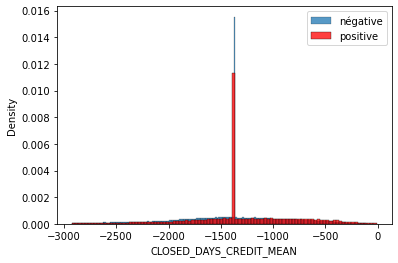

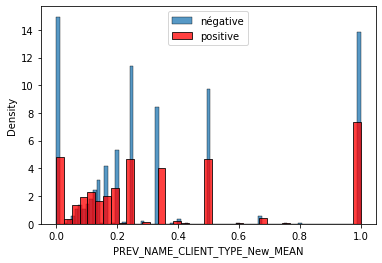

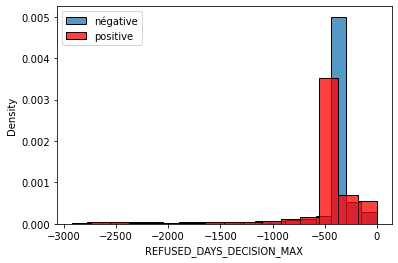

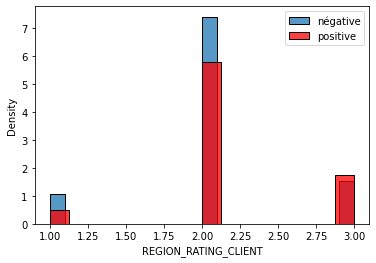

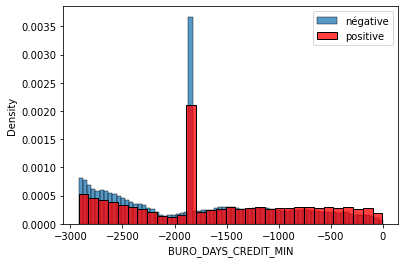

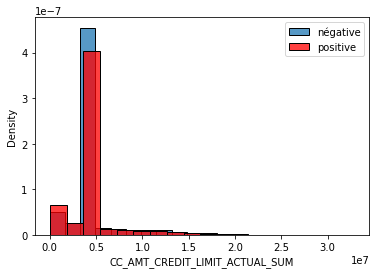

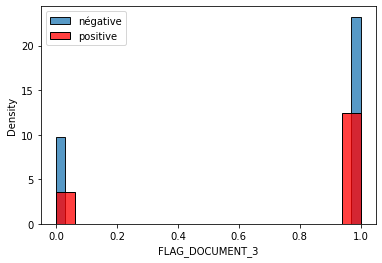

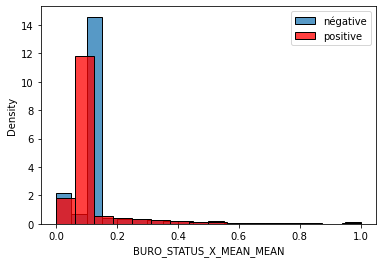

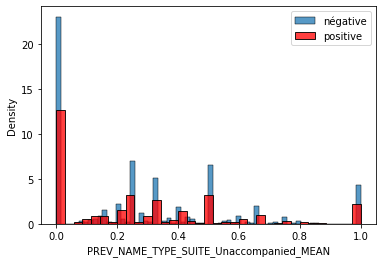

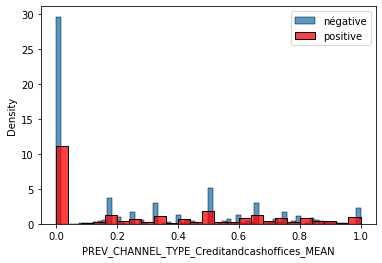

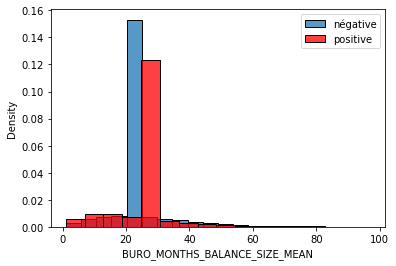

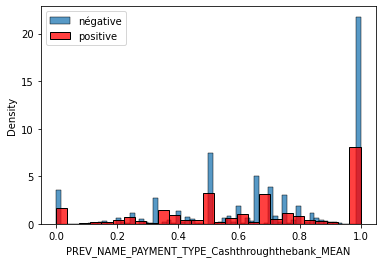

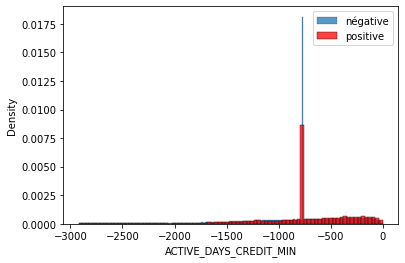

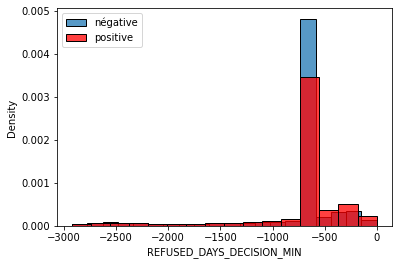

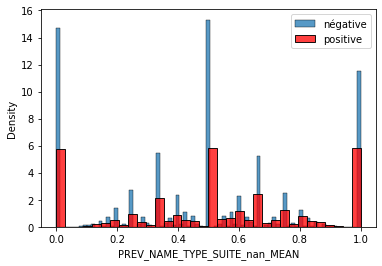

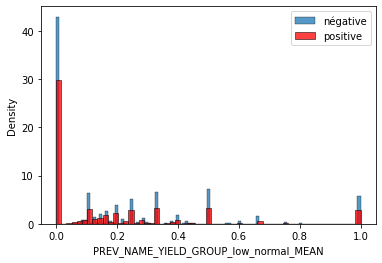

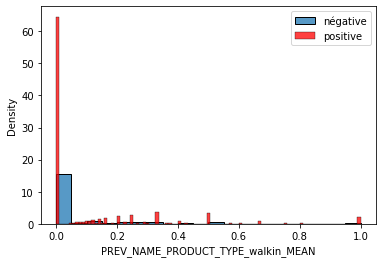

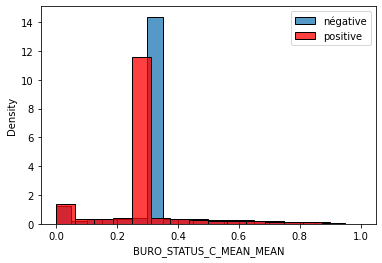

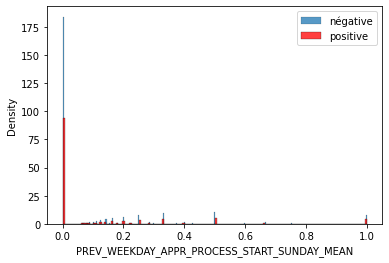

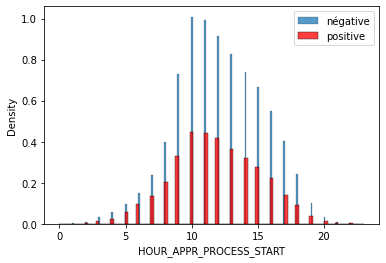

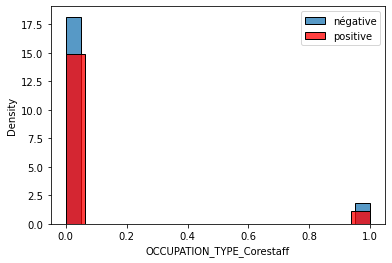

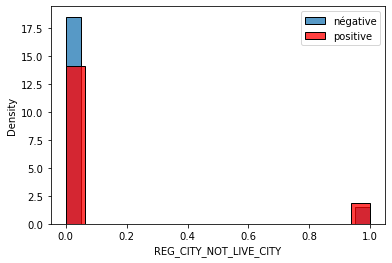

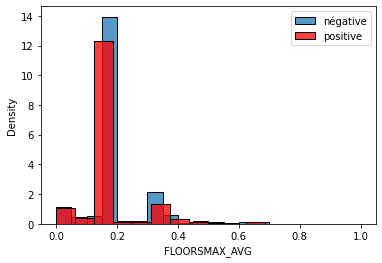

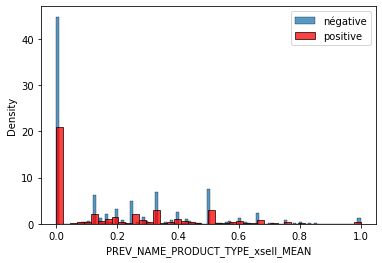

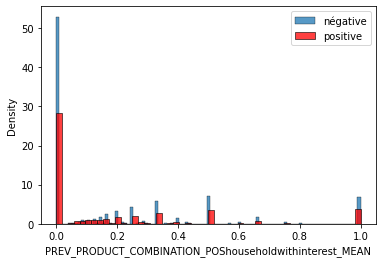

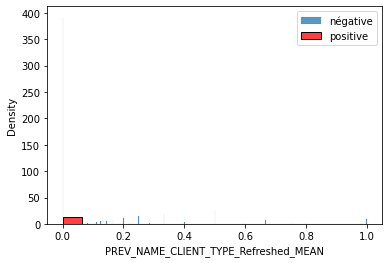

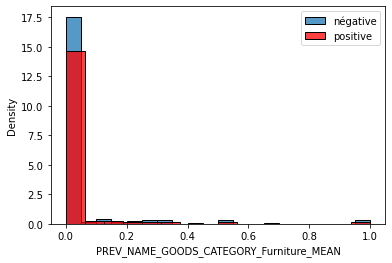

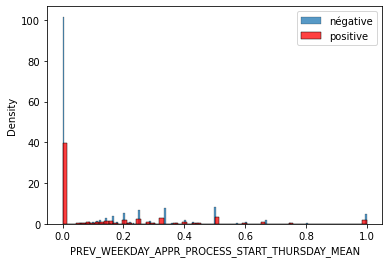

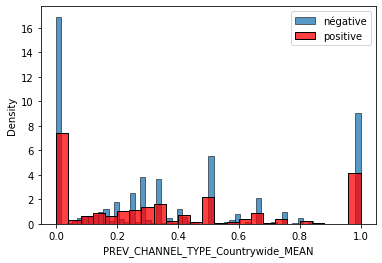

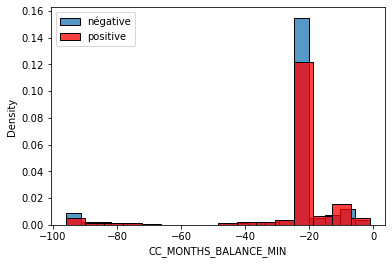

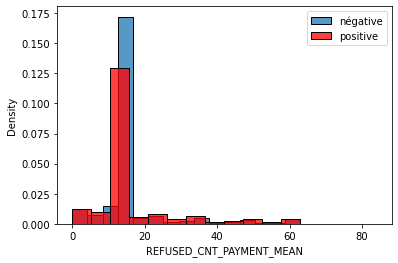

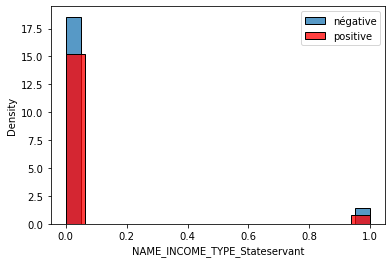

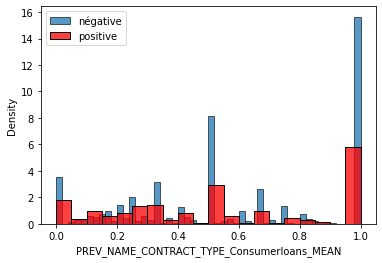

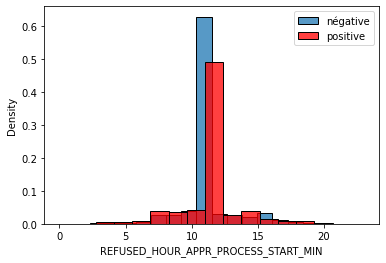

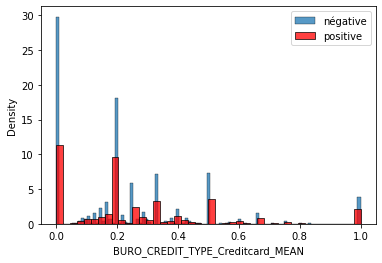

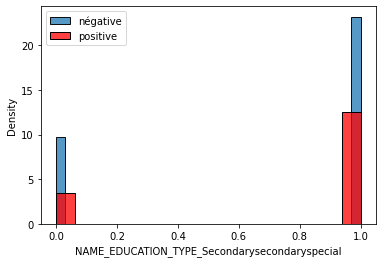

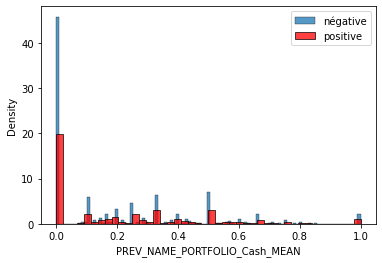

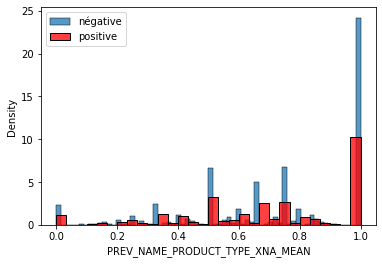

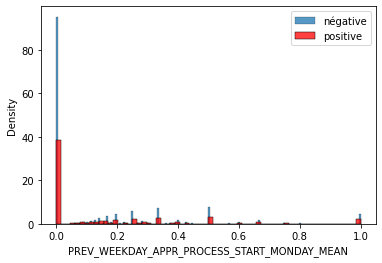

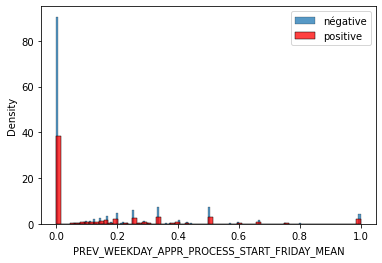

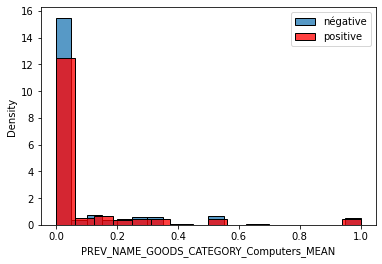

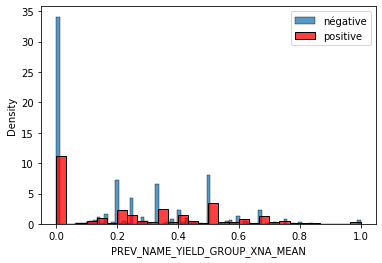

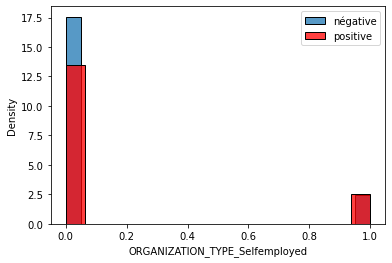

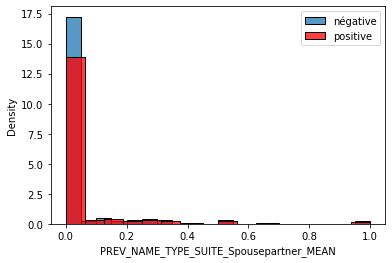

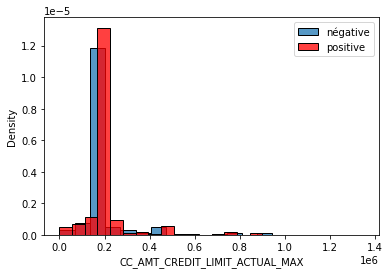

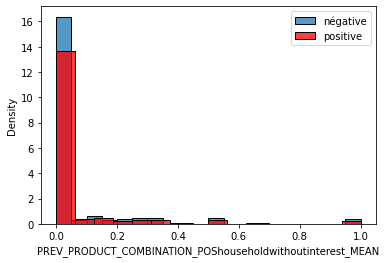

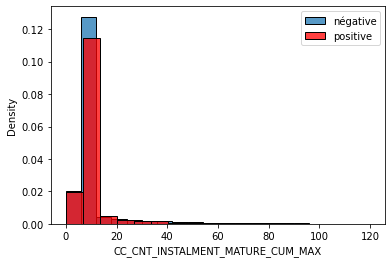

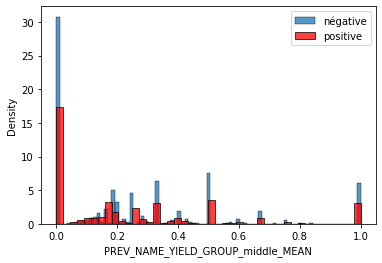

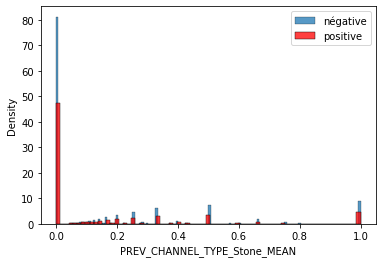

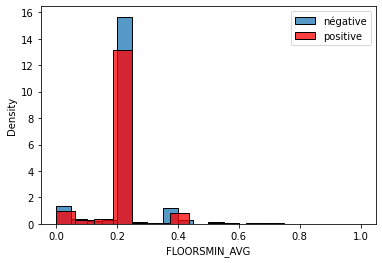

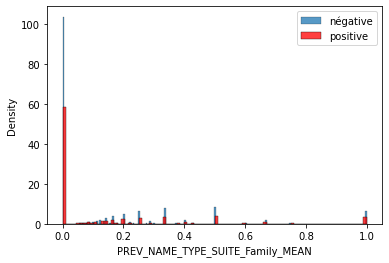

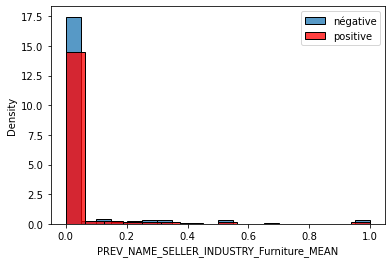

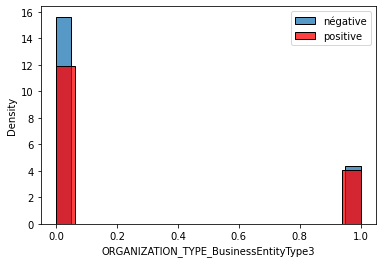

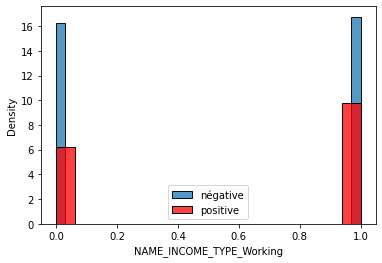

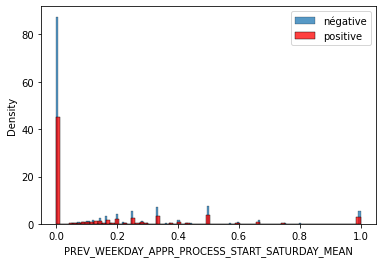

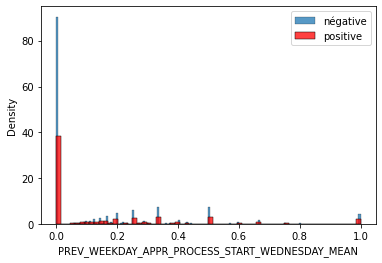

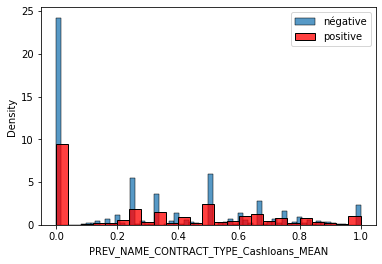

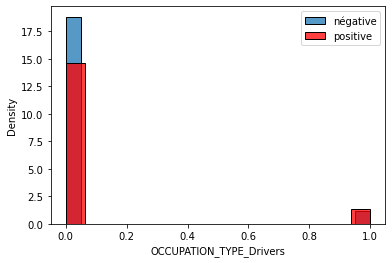

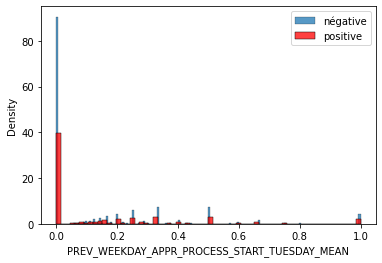

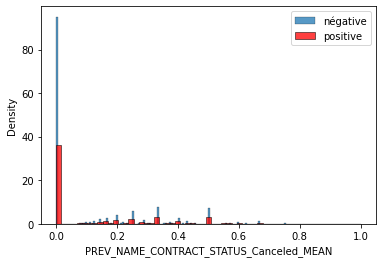

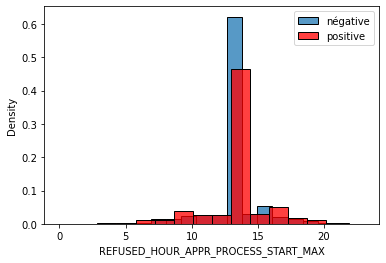

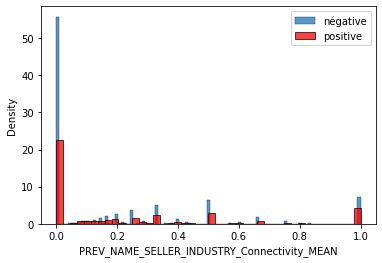

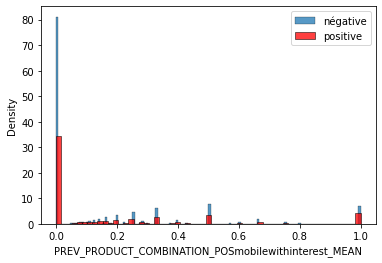

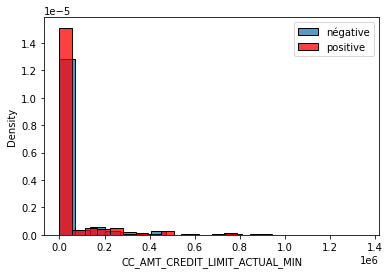

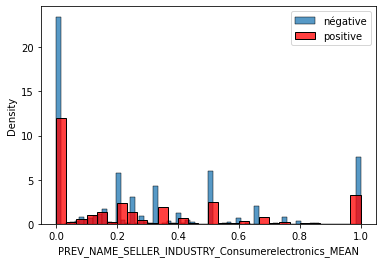

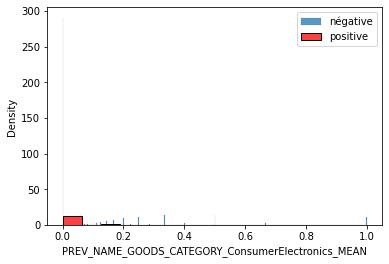

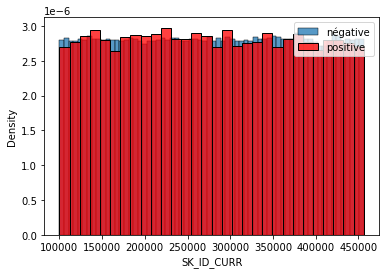

In [28]:
for col in tqdm(columns):
    plt.figure()    
    sns.histplot(negative_df_imp[col], label = 'négative', stat='density')
    sns.histplot(positive_df_imp[col], label = 'positive', color='r',stat='density')
    plt.legend()

Starting LightGBM. Train shape: (307507, 99)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.77608	training's binary_logloss: 0.240963	valid_1's auc: 0.762519	valid_1's binary_logloss: 0.250216
[400]	training's auc: 0.794189	training's binary_logloss: 0.234234	valid_1's auc: 0.770168	valid_1's binary_logloss: 0.247411
[600]	training's auc: 0.80721	training's binary_logloss: 0.22966	valid_1's auc: 0.771966	valid_1's binary_logloss: 0.246724
[800]	training's auc: 0.818184	training's binary_logloss: 0.22579	valid_1's auc: 0.773153	valid_1's binary_logloss: 0.246369
[1000]	training's auc: 0.827903	training's binary_logloss: 0.222306	valid_1's auc: 0.773402	valid_1's binary_logloss: 0.246311
[1200]	training's auc: 0.836842	training's binary_logloss: 0.21904	valid_1's auc: 0.773901	valid_1's binary_logloss: 0.246188
Early stopping, best iteration is:
[1145]	training's auc: 0.834499	training's binary_logloss: 0.219919	valid_1's auc: 0.773997	valid_1's bin

[400]	training's auc: 0.793397	training's binary_logloss: 0.234907	valid_1's auc: 0.777595	valid_1's binary_logloss: 0.242201
[600]	training's auc: 0.806555	training's binary_logloss: 0.230335	valid_1's auc: 0.780397	valid_1's binary_logloss: 0.241116
[800]	training's auc: 0.817471	training's binary_logloss: 0.226498	valid_1's auc: 0.781453	valid_1's binary_logloss: 0.240638
[1000]	training's auc: 0.827102	training's binary_logloss: 0.223052	valid_1's auc: 0.781983	valid_1's binary_logloss: 0.240435
[1200]	training's auc: 0.835712	training's binary_logloss: 0.219835	valid_1's auc: 0.782428	valid_1's binary_logloss: 0.240255
[1400]	training's auc: 0.844146	training's binary_logloss: 0.21667	valid_1's auc: 0.782916	valid_1's binary_logloss: 0.240096
[1600]	training's auc: 0.852078	training's binary_logloss: 0.213623	valid_1's auc: 0.783284	valid_1's binary_logloss: 0.240013
[1800]	training's auc: 0.85922	training's binary_logloss: 0.210719	valid_1's auc: 0.783402	valid_1's binary_logloss

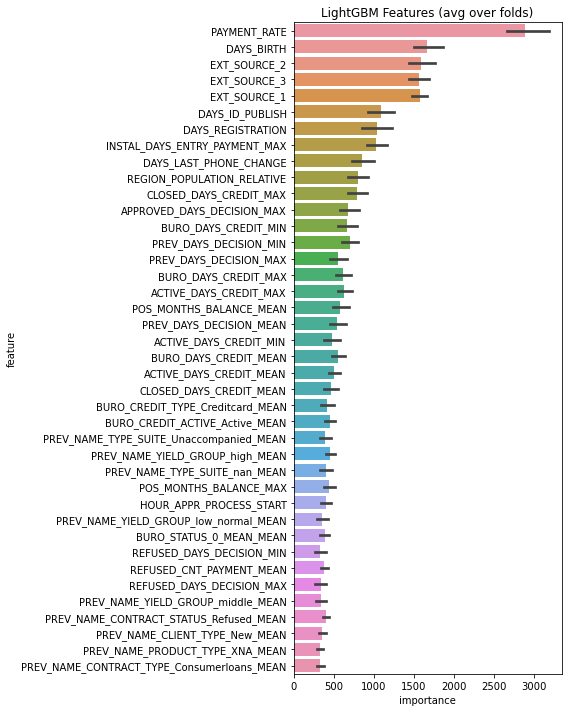

In [30]:
feat_importance = kfold_lightgbm(train_df_imp, num_folds=10)

Après imputation le AUROC score reste **0.77**.

# SelectKBest

In [14]:
#train_df = pd.read_csv('data/traited/df_train_99.csv')

In [13]:
train_df_imp.replace([np.inf, -np.inf], np.nan, inplace=True)

In [31]:
x_train = train_df_imp.loc[:, train_df_imp.columns!='TARGET']
y_train = train_df_imp.loc[:, train_df_imp.columns=='TARGET']

In [32]:
print(x_train.shape)
print(y_train.shape)

(307507, 98)
(307507, 1)


In [12]:
from sklearn.feature_selection import SelectKBest

In [41]:
select_feature = SelectKBest(k=66).fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
selected_features_df = pd.DataFrame({'Feature':list(x_train.columns),
                                     'Scores':select_feature.scores_})
kbest_score = selected_features_df.sort_values(by='Scores', ascending=False).reset_index(drop=True)
kbest_score

,Feature,Scores
0,EXT_SOURCE_2,8109.493617
1,EXT_SOURCE_3,7659.890000
2,EXT_SOURCE_1,3036.648251
3,BURO_DAYS_CREDIT_MEAN,2085.799547
4,DAYS_BIRTH,1894.090368
5,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,1877.607853
6,BURO_CREDIT_ACTIVE_Active_MEAN,1457.800172
7,BURO_DAYS_CREDIT_MIN,1402.770598
8,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,1224.876270
9,REGION_RATING_CLIENT,1070.545333


In [43]:
x_train_kbest = select_feature.transform(x_train)
print(x_train_kbest.shape)

(307507, 66)


C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\1602086893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_imp_kbest_66['TARGET'] = train_df_imp['TARGET']


Starting LightGBM. Train shape: (307507, 67)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.768288	training's binary_logloss: 0.242992	valid_1's auc: 0.756249	valid_1's binary_logloss: 0.251939
[400]	training's auc: 0.784402	training's binary_logloss: 0.237267	valid_1's auc: 0.761262	valid_1's binary_logloss: 0.249937
[600]	training's auc: 0.795849	training's binary_logloss: 0.233455	valid_1's auc: 0.762781	valid_1's binary_logloss: 0.24938
[800]	training's auc: 0.805355	training's binary_logloss: 0.230234	valid_1's auc: 0.763056	valid_1's binary_logloss: 0.249261
[1000]	training's auc: 0.813839	training's binary_logloss: 0.227351	valid_1's auc: 0.763347	valid_1's binary_logloss: 0.249219
[1200]	training's auc: 0.822091	training's binary_logloss: 0.224469	valid_1's auc: 0.763229	valid_1's binary_logloss: 0.249274
Early stopping, best iteration is:
[1092]	training's auc: 0.81761	training's binary_logloss: 0.226023	valid_1's auc: 0.763456	valid_1's 

[200]	training's auc: 0.769079	training's binary_logloss: 0.243547	valid_1's auc: 0.747036	valid_1's binary_logloss: 0.247448
[400]	training's auc: 0.784892	training's binary_logloss: 0.237841	valid_1's auc: 0.753181	valid_1's binary_logloss: 0.245554
[600]	training's auc: 0.79648	training's binary_logloss: 0.233964	valid_1's auc: 0.754839	valid_1's binary_logloss: 0.245089
[800]	training's auc: 0.805939	training's binary_logloss: 0.230752	valid_1's auc: 0.755436	valid_1's binary_logloss: 0.244978
[1000]	training's auc: 0.81468	training's binary_logloss: 0.227753	valid_1's auc: 0.755809	valid_1's binary_logloss: 0.244878
Early stopping, best iteration is:
[975]	training's auc: 0.813654	training's binary_logloss: 0.228107	valid_1's auc: 0.755861	valid_1's binary_logloss: 0.244866
Fold 10 AUC : 0.7559


Full AUC score 0.7596


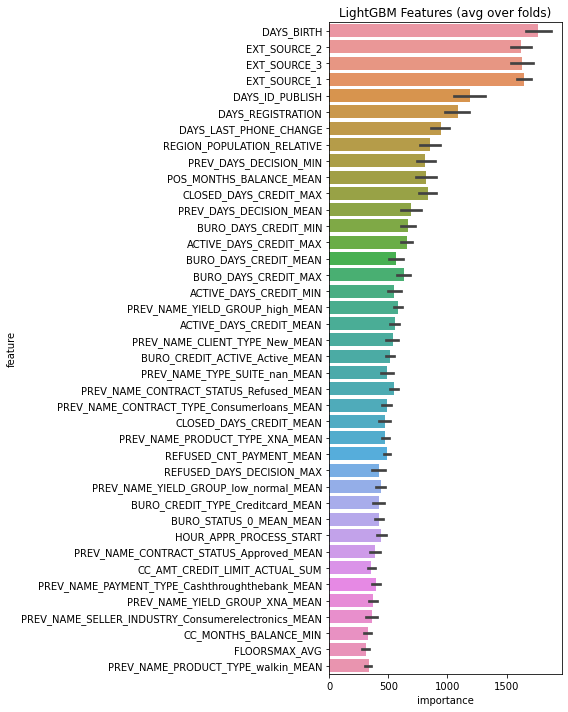

In [47]:
feature_to_keep = list(kbest_score.iloc[:66, 0])
train_df_imp_kbest_66 = train_df_imp[feature_to_keep]
train_df_imp_kbest_66['TARGET'] = train_df_imp['TARGET']
feat_importance = kfold_lightgbm(train_df_imp_kbest_66, num_folds=10)

Après SelectKBest **65** features, le AUROC score reste **0.76**.

In [62]:
train_df_imp_kbest_66.to_csv('data/traited/df_train_66.csv', index = False)

In [61]:
train_df_imp_kbest_66['SK_ID_CURR'] = train_df_imp['SK_ID_CURR']

C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\1606656688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_imp_kbest_66['SK_ID_CURR'] = train_df_imp['SK_ID_CURR']


In [63]:
train_df_imp_kbest_66.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_DAYS_CREDIT_MIN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,ACTIVE_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,ACTIVE_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MAX,PREV_DAYS_DECISION_MEAN,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,BURO_MONTHS_BALANCE_SIZE_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,DAYS_REGISTRATION,FLOORSMAX_AVG,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,REGION_POPULATION_RELATIVE,ACTIVE_DAYS_CREDIT_MIN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,POS_MONTHS_BALANCE_MEAN,REFUSED_CNT_PAYMENT_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,NAME_CONTRACT_TYPE_Cashloans,PREV_NAME_CONTRACT_TYPE_Consumerloans_MEAN,BURO_STATUS_C_MEAN_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,OCCUPATION_TYPE_Drivers,BURO_CREDIT_TYPE_Creditcard_MEAN,CLOSED_DAYS_CREDIT_MAX,ORGANIZATION_TYPE_Selfemployed,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,CC_MONTHS_BALANCE_MIN,NAME_FAMILY_STATUS_Married,BURO_STATUS_0_MEAN_MEAN,HOUR_APPR_PROCESS_START,REFUSED_HOUR_APPR_PROCESS_START_MIN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,ORGANIZATION_TYPE_BusinessEntityType3,PREV_PRODUCT_COMBINATION_POSmobilewithinterest_MEAN,NAME_INCOME_TYPE_Stateservant,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,FLOORSMIN_AVG,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN,OCCUPATION_TYPE_Corestaff,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,PREV_NAME_TYPE_SUITE_Family_MEAN,REFUSED_DAYS_DECISION_MAX,TARGET,SK_ID_CURR
0,0.262949,0.139376,0.083037,-874.000000,-9461,0.000000,0.250,-1437.0,1.000000,2,0.000000,1,0,-1134.0,0,-572.500000,-606.0,-2120,1,-103.0,-974.500000,-103.0,-606.000000,0,1,13.75,0.000000,-3648.0,0.0833,1.000000,0.000000,0.018801,-1042.0,0.000000,-10.000000,13.5,1.000000,1,1.000000,0.175426,0.000000,0,0.5,-476.0,0,0.000000,0.0,0.000000,-22.0,0,0.406960,10,11.0,0.000000,1,0.000000,0,1.000000,1.000000,0.1250,0.000000,0.0,0,3960000.0,0.000000,-396.0,1.0,100002
1,0.622246,0.535276,0.311267,-1400.750000,-16765,0.000000,0.250,-2586.0,1.000000,1,0.000000,0,1,-828.0,1,-606.000000,-2341.0,-291,0,-606.0,-1665.666667,-606.0,-1305.000000,0,1,24.75,0.000000,-1186.0,0.2917,0.333333,0.000000,0.003541,-606.0,0.666667,-43.785714,13.5,0.000000,1,0.666667,0.308514,0.000000,0,0.5,-775.0,0,0.333333,0.0,0.333333,-22.0,1,0.436423,11,11.0,0.666667,0,0.000000,1,0.000000,0.666667,0.3333,0.333333,0.0,1,3960000.0,0.666667,-396.0,0.0,100003
2,0.555912,0.729567,0.505998,-867.000000,-19046,0.000000,0.000,-1326.0,1.000000,2,0.000000,1,0,-815.0,0,-537.309524,-815.0,-2531,1,-258.0,-867.000000,-408.0,-815.000000,0,0,24.75,0.000000,-4260.0,0.1667,0.000000,0.000000,0.010032,-764.0,1.000000,-25.500000,13.5,0.000000,0,1.000000,0.308514,1.000000,0,0.0,-408.0,0,0.000000,0.0,0.000000,-22.0,0,0.436423,9,11.0,0.000000,0,0.000000,0,1.000000,1.000000,0.2083,0.000000,0.0,0,3960000.0,0.000000,-396.0,0.0,100004
3,0.650442,0.535276,0.505998,-1050.571429,-19005,0.111111,0.375,-1827.0,0.555556,2,0.000000,1,0,-617.0,1,-537.309524,-617.0,-2437,1,-258.0,-1366.555556,-300.0,-272.444444,0,1,24.75,0.444444,-9833.0,0.1667,0.222222,0.222222,0.008019,-764.0,0.444444,-9.619048,48.0,0.555556,1,0.222222,0.308514,0.000000,0,0.2,-729.0,0,0.000000,0.0,0.000000,-6.0,0,0.436423,17,15.0,0.000000,1,0.000000,0,0.111111,0.555556,0.2083,0.111111,0.0,0,1620000.0,0.111111,-181.0,0.0,100006
4,0.322738,0.535276,0.505998,-1149.000000,-19932,0.000000,0.000,-1149.0,1.000000,2,0.166667,1,0,-1106.0,0,-537.309524,-2357.0,-3458,1,-258.0,-1149.000000,-1149.0,-1222.833333,0,0,24.75,0.000000,-4311.0,0.1667,0.000000,0.500000,0.028663,-7

# RFE

In [51]:
# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
    #nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    verbose=-1, )

In [52]:
x_train = train_df_imp_kbest_66.loc[:, train_df_imp_kbest_66.columns!='TARGET']
y_train = train_df_imp_kbest_66.loc[:, train_df_imp_kbest_66.columns=='TARGET']

In [55]:
rfe = RFE(estimator=clf, step=1)
rfe = rfe.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [57]:
selected_rfe_features = pd.DataFrame({'Feature':list(x_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking').reset_index(drop=True)

,Feature,Ranking
0,EXT_SOURCE_2,1
1,PREV_DAYS_DECISION_MEAN,1
2,BURO_MONTHS_BALANCE_SIZE_MEAN,1
3,DAYS_REGISTRATION,1
4,PREV_NAME_YIELD_GROUP_low_normal_MEAN,1
5,PREV_NAME_YIELD_GROUP_high_MEAN,1
6,REGION_POPULATION_RELATIVE,1
7,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,1
8,BURO_DAYS_CREDIT_MAX,1
9,POS_MONTHS_BALANCE_MEAN,1


In [59]:
df = selected_rfe_features.sort_values(by='Ranking').reset_index(drop=True)
feature_to_keep = list(df.loc[df['Ranking']==1, 'Feature'])
len(feature_to_keep)

33

In [64]:
train_df_imp_kbest_rfe_35 = train_df_imp_kbest_66[feature_to_keep]
train_df_imp_kbest_rfe_35['TARGET'] = train_df_imp_kbest_66.loc[:, 'TARGET']
train_df_imp_kbest_rfe_35['SK_ID_CURR'] = train_df_imp_kbest_66.loc[:, 'SK_ID_CURR']
print(train_df_imp_kbest_rfe_35.shape)
train_df_imp_kbest_rfe_35.head()

(307507, 35)


C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\3512905116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_imp_kbest_rfe_35['TARGET'] = train_df_imp_kbest_66.loc[:, 'TARGET']
C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\3512905116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_imp_kbest_rfe_35['SK_ID_CURR'] = train_df_imp_kbest_66.loc[:, 'SK_ID_CURR']


,EXT_SOURCE_2,PREV_DAYS_DECISION_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,DAYS_REGISTRATION,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,BURO_DAYS_CREDIT_MAX,POS_MONTHS_BALANCE_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,CLOSED_DAYS_CREDIT_MAX,BURO_STATUS_0_MEAN_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,PREV_NAME_TYPE_SUITE_nan_MEAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MIN,EXT_SOURCE_3,EXT_SOURCE_1,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,BURO_CREDIT_ACTIVE_Active_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,DAYS_LAST_PHONE_CHANGE,REFUSED_DAYS_DECISION_MAX,ACTIVE_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.262949,-606.000000,13.75,-3648.0,1.000000,0.000000,0.018801,0.000000,-103.0,-10.000000,0.5,-476.0,0.406960,10,1.000000,0.000000,3960000.0,1.000000,-974.500000,-1042.0,-1437.0,0.139376,0.083037,-874.000000,-9461,0.250,-103.0,1.000000,-1134.0,-396.0,-572.500000,-606.0,-2120,1.0,100002
1,0.622246,-1305.000000,24.75,-1186.0,0.333333,0.000000,0.003541,0.666667,-606.0,-43.785714,0.5,-775.0,0.436423,11,0.666667,0.333333,3960000.0,0.000000,-1665.666667,-606.0,-2586.0,0.535276,0.311267,-1400.750000,-16765,0.250,-606.0,1.000000,-828.0,-396.0,-606.000000,-2341.0,-291,0.0,100003
2,0.555912,-815.000000,24.75,-4260.0,0.000000,0.000000,0.010032,1.000000,-408.0,-25.500000,0.0,-408.0,0.436423,9,1.000000,0.000000,3960000.0,0.000000,-867.000000,-764.0,-1326.0,0.729567,0.505998,-867.000000,-19046,0.000,-258.0,1.000000,-815.0,-396.0,-537.309524,-815.0,-2531,0.0,100004
3,0.650442,-272.444444,24.75,-9833.0,0.222222,0.222222,0.008019,0.444444,-300.0,-9.619048,0.2,-729.0,0.436423,17,0.555556,0.111111,1620000.0,0.555556,-1366.555556,-764.0,-1827.0,0.535276,0.505998,-1050.571429,-19005,0.375,-258.0,0.555556,-617.0,-181.0,-537.309524,-617.0,-2437,0.0,100006
4,0.322738,-1222.833333,24.75,-4311.0,0.000000,0.500000,0.028663,0.833333,-1149.0,-33.636364,0.0,-1149.0,0.436423,11,0.333333,0.500000,3960000.0,0.333333,-1149.000000,-764.0,-1149.0,0.535276,0.505998,-1149.000000,-19932,0.000,-258.0,1.000000,-1106.0,-396.0,-537.309524,-2357.0,-3458,0.0,100007


Starting LightGBM. Train shape: (307507, 35)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.757794	training's binary_logloss: 0.24582	valid_1's auc: 0.747941	valid_1's binary_logloss: 0.254264
[400]	training's auc: 0.772449	training's binary_logloss: 0.240982	valid_1's auc: 0.751685	valid_1's binary_logloss: 0.252874
[600]	training's auc: 0.783146	training's binary_logloss: 0.237657	valid_1's auc: 0.752273	valid_1's binary_logloss: 0.252694
[800]	training's auc: 0.792992	training's binary_logloss: 0.2346	valid_1's auc: 0.752265	valid_1's binary_logloss: 0.25273
Early stopping, best iteration is:
[606]	training's auc: 0.783438	training's binary_logloss: 0.237564	valid_1's auc: 0.752311	valid_1's binary_logloss: 0.252673
Fold  1 AUC : 0.7523


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.758921	training's binary_logloss: 0.246096	valid_1's auc: 0.740944	valid_1's binary_logloss: 0.251186
[400]	training's auc:

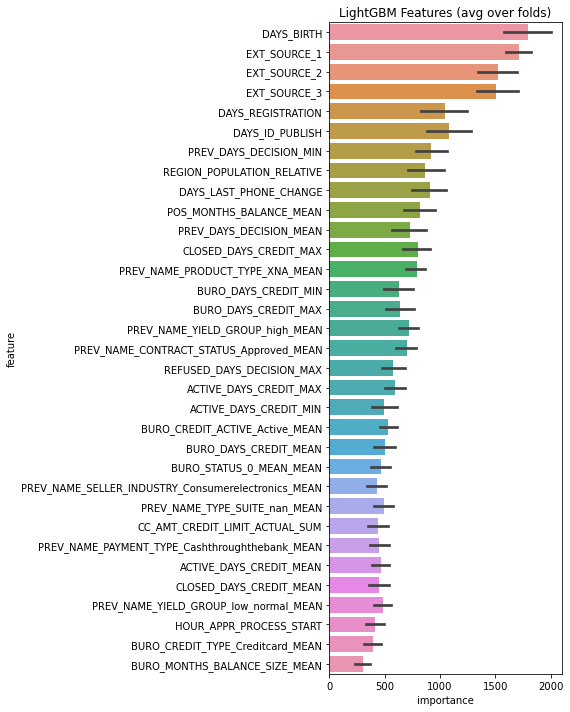

In [65]:
feat_importance = kfold_lightgbm(train_df_imp_kbest_rfe_35, num_folds=10)

In [72]:
feat_importance.groupby("feature").agg("mean").sort_values(by="importance", ascending=False)

,importance,fold
feature,,
DAYS_BIRTH,1791.5,5.5
EXT_SOURCE_1,1712.3,5.5
EXT_SOURCE_2,1527.1,5.5
EXT_SOURCE_3,1509.6,5.5
DAYS_ID_PUBLISH,1078.3,5.5
DAYS_REGISTRATION,1043.4,5.5
PREV_DAYS_DECISION_MIN,919.0,5.5
DAYS_LAST_PHONE_CHANGE,907.3,5.5
REGION_POPULATION_RELATIVE,866.7,5.5


In [66]:
train_df_imp_kbest_rfe_35.to_csv('data/traited/df_train_35.csv', index = False)

Après RFE **35** features, le AUROC score reste **0.747**.

In [73]:
df = train_df_imp_kbest_rfe_35.copy()
positive_df = df[df['TARGET']==1]
negative_df = df[df['TARGET']==0]

 59%|████████████████████████████████████████████████▏                                 | 20/34 [00:05<00:03,  3.50it/s]C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\4253636004.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.41it/s]


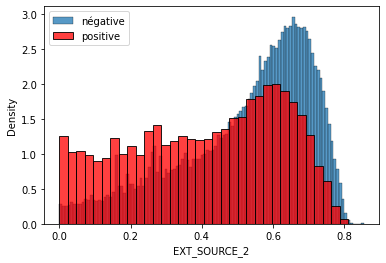

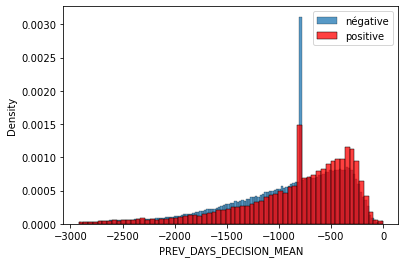

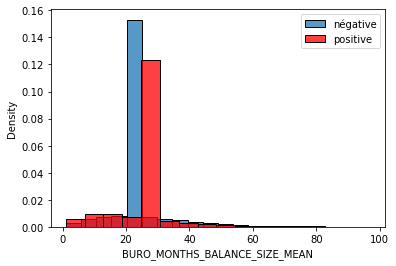

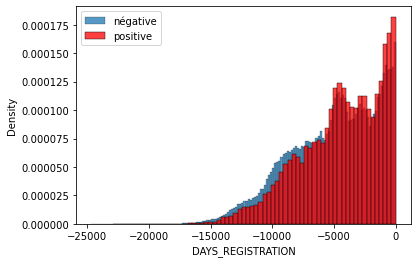

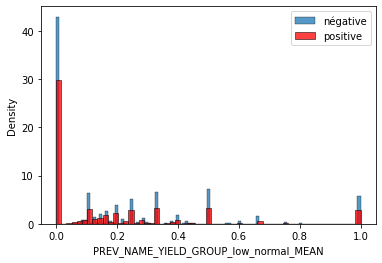

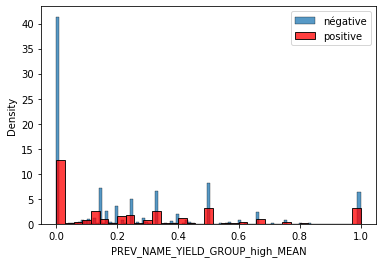

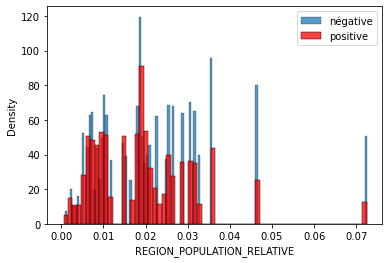

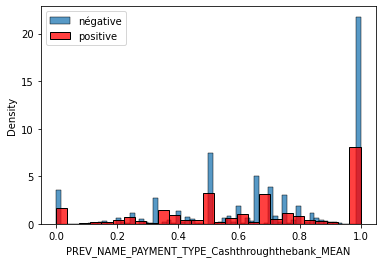

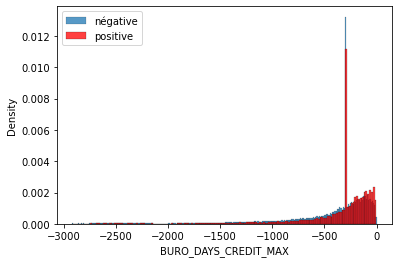

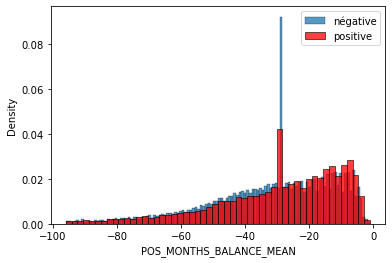

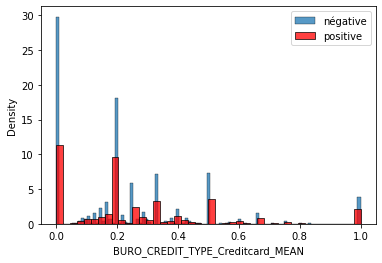

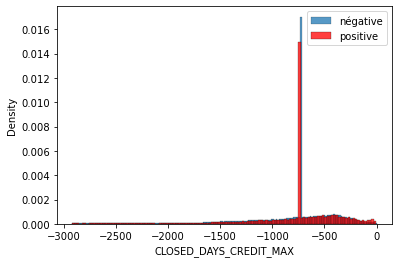

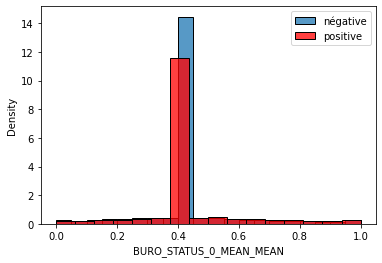

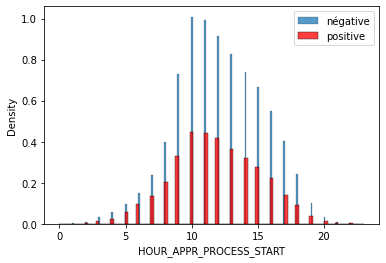

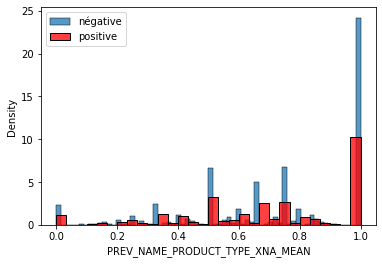

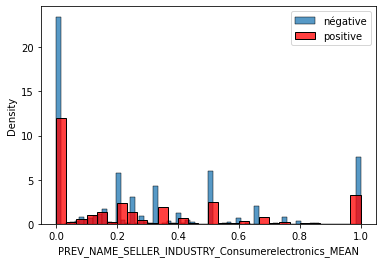

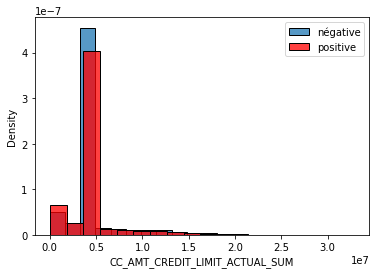

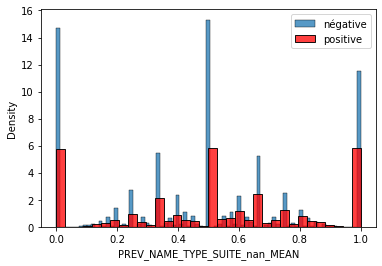

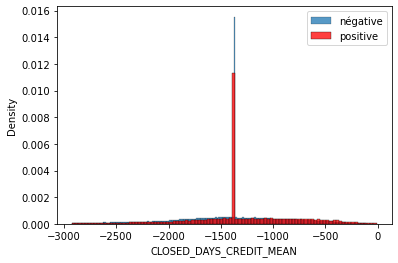

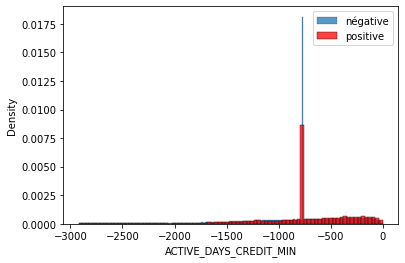

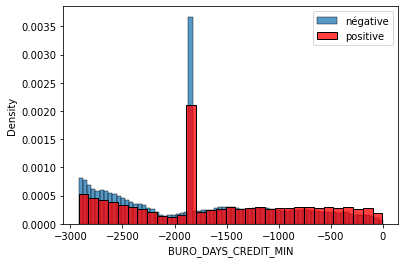

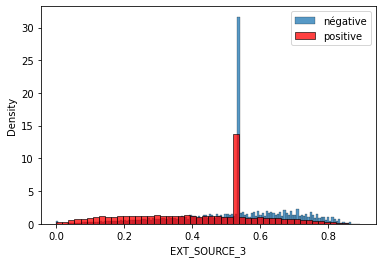

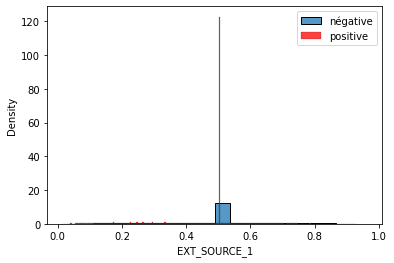

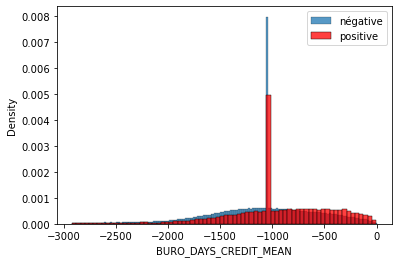

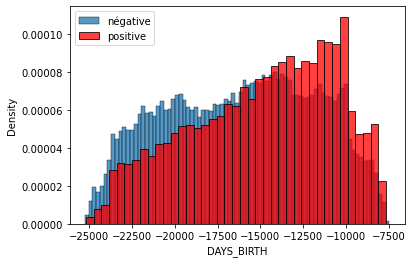

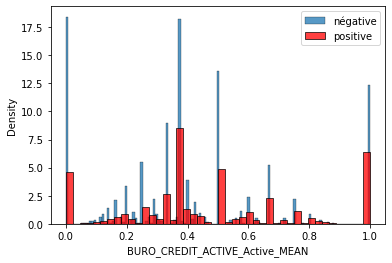

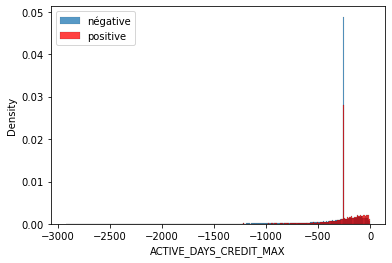

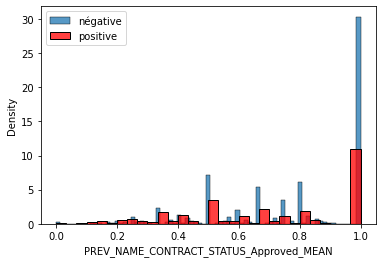

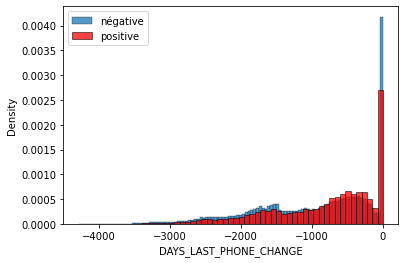

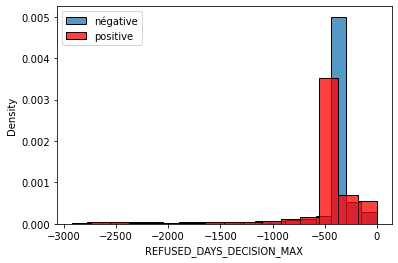

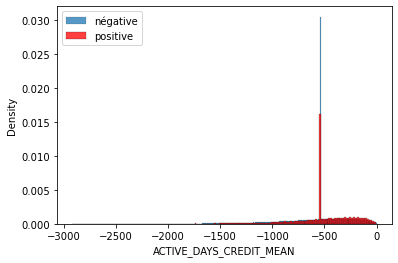

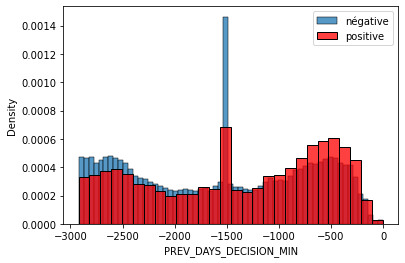

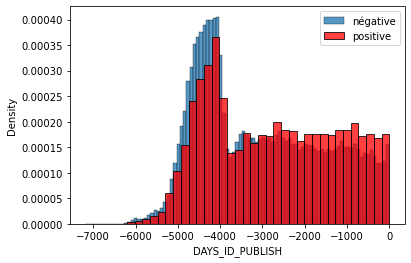

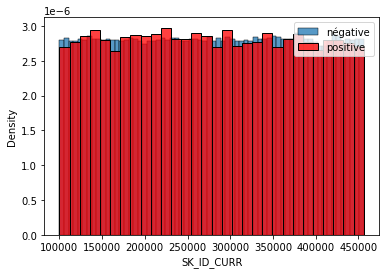

In [74]:
columns = df.drop(columns = ["TARGET"]).columns
for col in tqdm(columns):
    plt.figure()    
    sns.histplot(negative_df[col], label = 'négative', stat='density')
    sns.histplot(positive_df[col], label = 'positive', color='r',stat='density')
    plt.legend()

 59%|████████████████████████████████████████████████▏                                 | 20/34 [00:01<00:00, 18.09it/s]C:\Users\rimla\AppData\Local\Temp\ipykernel_16852\2714620536.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.51it/s]


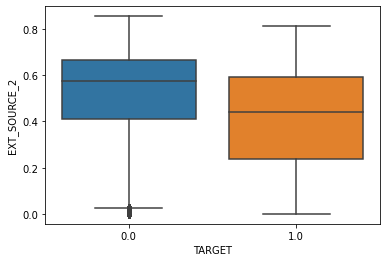

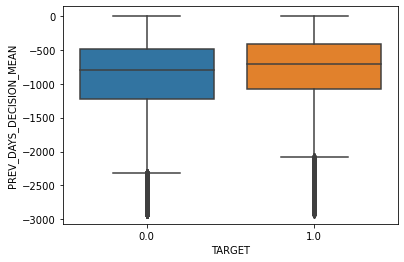

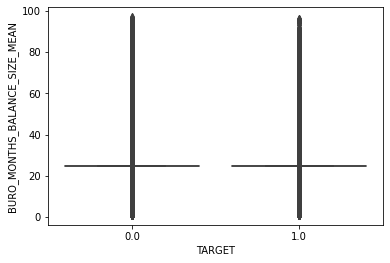

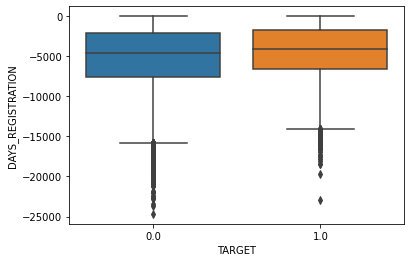

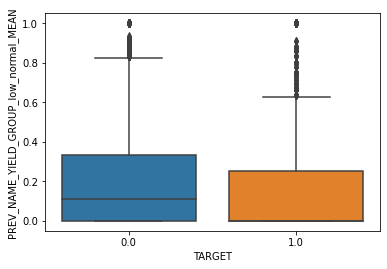

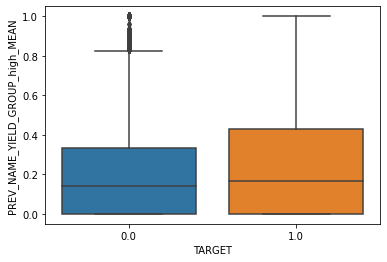

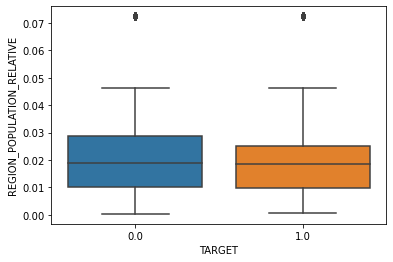

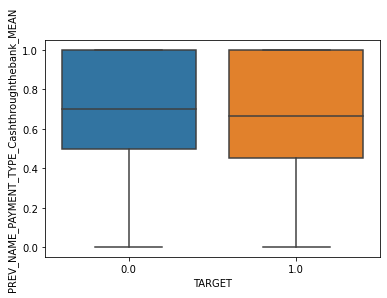

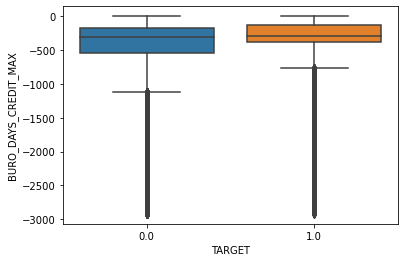

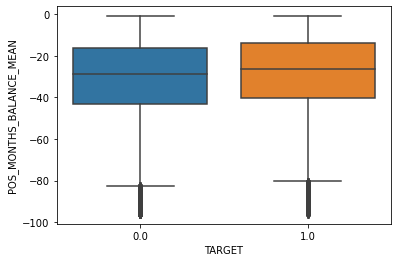

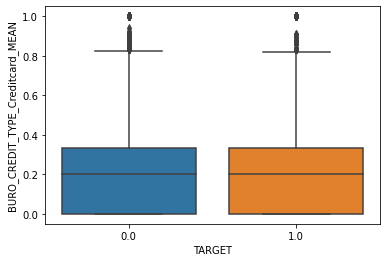

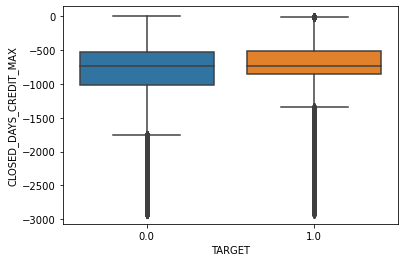

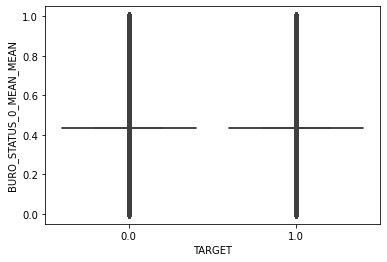

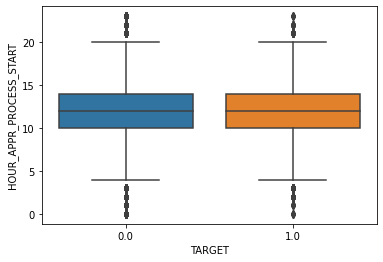

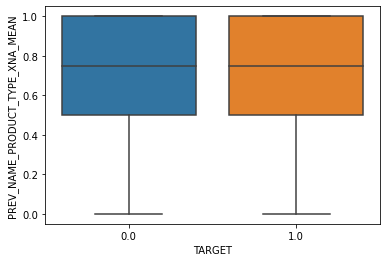

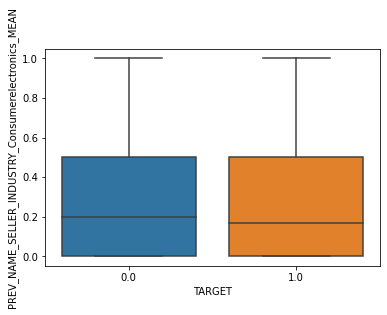

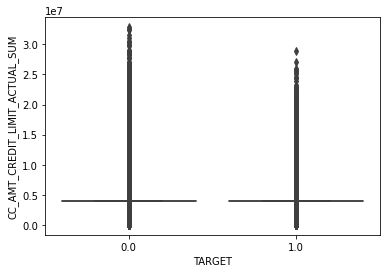

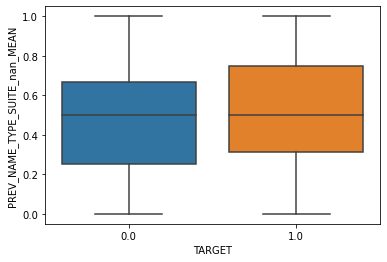

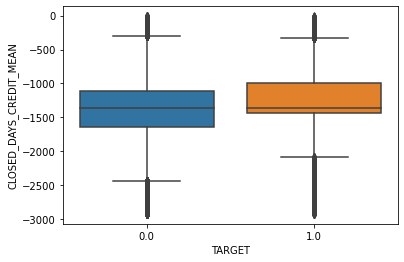

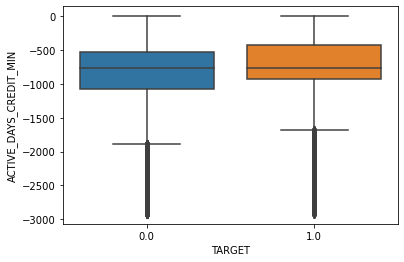

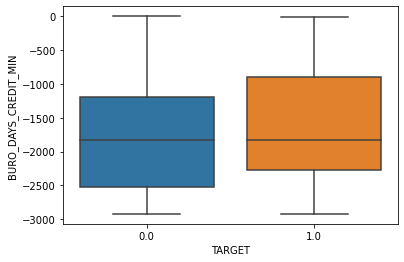

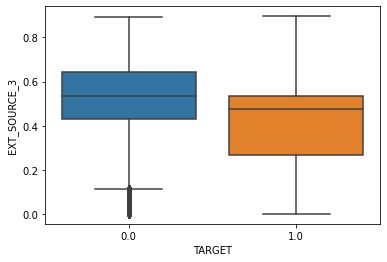

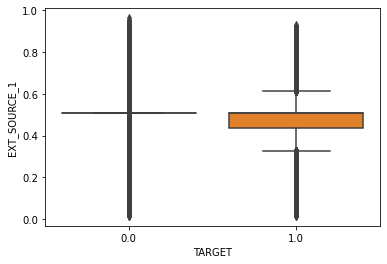

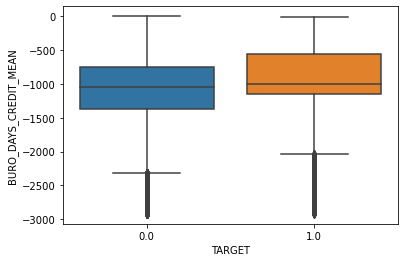

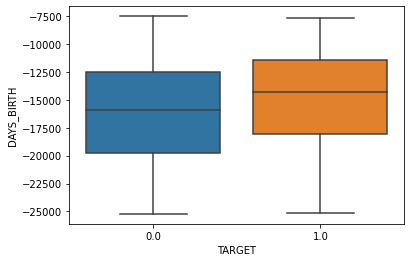

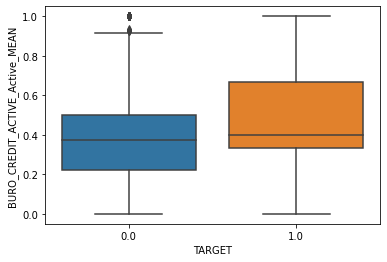

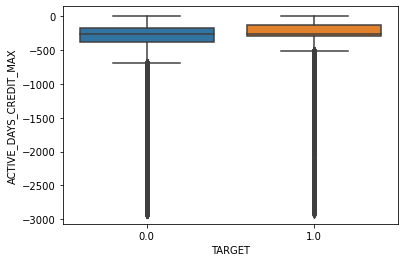

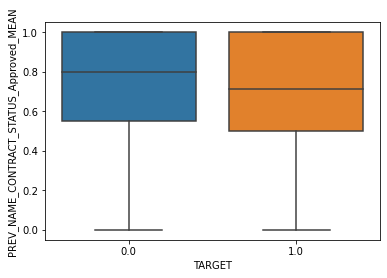

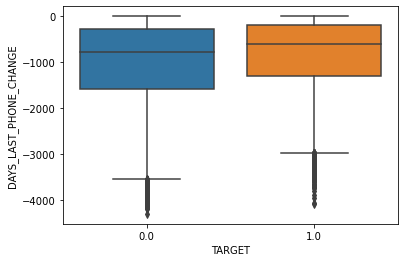

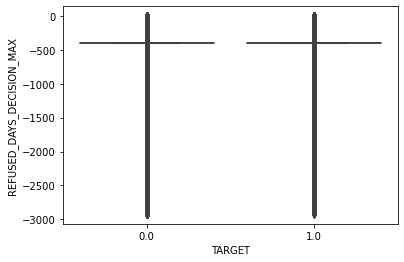

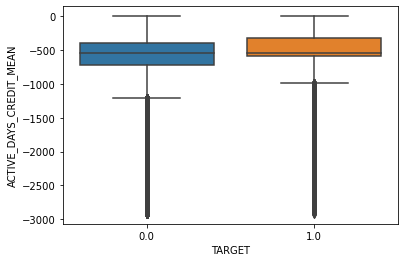

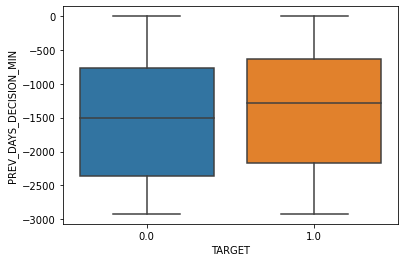

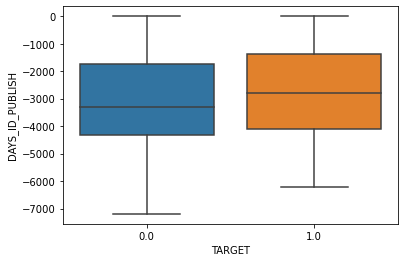

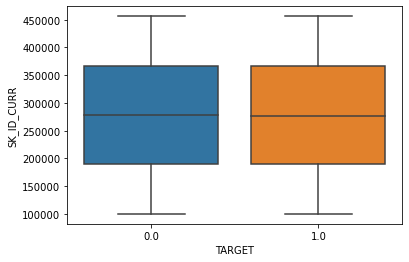

In [77]:
for col in tqdm(columns):
    plt.figure()    
    sns.boxplot(data= df, x= "TARGET", y = col);
plt.show()

# Conclusion 

Dans ce notebook, nous avons utilisé deux méthodes supplimentaires de sélection de variables :

* SelectKBest
* RFE

Initialement, nous avions **797** avec un score AUC ROC de validation croisée (cv=10) de **0.79**.
En utilisant les méthodes précédentes, nous avons réduit encore le nombre de variables de:
* **99** avec un score AUC ROC de validation croisée (cv=10) de **0.77** à
* **35** avec un score AUC ROC de validation croisée (cv=10) de **0.75**.

In [ ]:
# df = pd.read_csv('data/traited/df_train_35.csv')
# columns_ = df.columns
# targets_ = ['Bon_client', 'Client_a_risque']
# features_ = df.drop(columns=["SK_ID_CURR", 'TARGET']).columns
# columns_ = df.columns
# del df
## depuis le notebooke BAHROUN_Rim_1_notebook_042023, on récupére les datas train et test agrégés avec tous les variables.
# train_df = pd.read_csv("data/traited/df_credit_train_col.csv", usecols=columns_)
# train_df = train_df.fillna(train_df.median())
# train_df.to_csv("data/traited/df_credit_train_35.csv", index=False)
# del train_df
# test_df = pd.read_csv("data/traited/df_credit_test_col.csv", usecols=columns_)
# test_df.loc[:, test_df.columns != 'TARGET'] = test_df.loc[:, test_df.columns != 'TARGET'].fillna(train_df.loc[:, train_df.columns != 'TARGET'].median())
# test_df.to_csv("data/traited/df_credit_test_35.csv", index=False)
# del test_df